# Goal:
To explore concepts of unsupervised learning and natural language processing. 

## Approach:
I'm going to analyze text from 10 authors in NLTK's Gutenberg corpus. These will be a variety of books, a few poetry, the bible, and some fiction.

## Target: 
My hope is that between bag of words (BOW) and tfidf I can create a feature set that allows for accurate prediction of the author of a text given a sample sentence.

In [1]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import gutenberg, stopwords
import spacy
import re
import gensim

nltk.download('gutenberg')


[nltk_data] Downloading package gutenberg to /Users/user/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

In [2]:
# Load spacy English module

### May have to enter this in terminal for spacy 'en': 
#user$ python3 -m spacy download 'en'
nlp = spacy.load('en')

In [3]:
# assign variables for all raw texts
sense = gutenberg.raw('austen-sense.txt')
bible = gutenberg.raw('bible-kjv.txt')
stories = gutenberg.raw('bryant-stories.txt')
busterbrown = gutenberg.raw('burgess-busterbrown.txt')
alice = gutenberg.raw('carroll-alice.txt')
thursday = gutenberg.raw('chesterton-thursday.txt')
parents = gutenberg.raw('edgeworth-parents.txt')
moby = gutenberg.raw('melville-moby_dick.txt')
paradise = gutenberg.raw('milton-paradise.txt')
leaves = gutenberg.raw('whitman-leaves.txt')

# Data preprocessing

Now that we have our texts, and before I do any further processing into features, I will remove some symbols, punctuation, whitespace, and words in an attempt to get only the text sentences from each book.

In [4]:
# Define text cleaning function
def text_cleaner(text):
    # Remove -- Double Dash
    text = re.sub(r'--', '', text)
    
    # Remove [Brackets] and any text within
    text = re.sub(r'[\[].*?[\]]', '', text)
    
    # Remove excess whitespace
    text = ' '.join(text.split())
    
    return text

# Remove idiosyncratic chapter/heading text
# Sense
sense = re.sub(r'CHAPTER \d+', '', sense)
# Bible
bible = re.sub(r'[0-9]', '', bible)
# Alice & Thursday
alice = re.sub(r'CHAPTER .*', '', alice)
thursday = re.sub(r'CHAPTER .*', '', thursday)
# Paradise
paradise = re.sub(r'Book .*', '', paradise)
# Leaves
leaves = re.sub(r'} .*|[0-9]', '', leaves)
# Stories/Busterbrown
stories = re.sub(r'[A-Z]+[A-Z].*|and [A-Z]+[A-Z].*', '', stories)
busterbrown = re.sub(r'[A-Z]+[A-Z].*|and [A-Z]+[A-Z].*', '', busterbrown)

In [5]:
texts = [sense, bible, stories, busterbrown, alice, thursday, parents, moby, paradise, leaves]
texts = [text[:1000000] for text in texts]
# Map our text cleaner to all texts
texts = list(map(text_cleaner, texts))

In [6]:
# Process all texts with nlp
texts = list(map(nlp, texts))

To limit the size of our dataset, we'll draw the first 1000 sentences for each of the 10 authors, totaling 10000 rows.

In [7]:
authors = ['Austen', 'KJV', 'Bryant', 'Burgess', 'Carroll', 'Chesterton', 'Edgeworth',
           'Melville', 'Milton', 'Whitman']

# Keep first 1000 sentences per text and add to a dataframe along with author name.
sents = []
for index1, text in enumerate(texts):
    for index2, sent in enumerate(text.sents):
        if index2 < 1000:
            sents.append((authors[index1], sent))
                          
sentences_df = pd.DataFrame(sents, columns=['author', 'sentence'])
sentences_df.tail()

,author,sentence
9995,Whitman,"(I, dare, not, desert, the, likes, of, you, in..."
9996,Whitman,"(I, believe, the, likes, of, you, shall, stand..."
9997,Whitman,"(The, curious, sympathy, one, feels, when, fee..."
9998,Whitman,"(,, The, circling, rivers, the, breath, ,, and..."
9999,Whitman,"(The, exquisite, realization, of, health, ;, O..."


In [8]:
sentences_df['author_code'] = pd.factorize(sentences_df['author'])[0]
print('author codes:', sentences_df['author_code'].unique())
sentences_df.head()

author codes: [0 1 2 3 4 5 6 7 8 9]


,author,sentence,author_code
0,Austen,"(The, family, of, Dashwood, had, long, been, s...",0
1,Austen,"(Their, estate, was, large, ,, and, their, res...",0
2,Austen,"(The, late, owner, of, this, estate, was, a, s...",0
3,Austen,"(But, her, death, ,, which, happened, ten, yea...",0
4,Austen,"(In, the, society, of, his, nephew, and, niece...",0


In [9]:
print(sentences_df.groupby('author').count())

            sentence  author_code
author                           
Austen          1000         1000
Bryant          1000         1000
Burgess         1000         1000
Carroll         1000         1000
Chesterton      1000         1000
Edgeworth       1000         1000
KJV             1000         1000
Melville        1000         1000
Milton          1000         1000
Whitman         1000         1000


Before running BOW, we need to tokenize each sentence and narrow down the amount of tokens we want to send into our BOW function. We only have 10000 rows in our dataframe, so we don't want to go very large on our feature set. Something around 800 would be a good starting point. After exploring that, we can try out a smaller feature set and see how the results compare.

Below, we'll tokenize the lemma forms of each word, remove stop words, create a dictionary of occurrences for each token, and find out what our occurrence threshold should be to end up with a good sized dataframe.

In [10]:
### Define function that creates a dict of {word : count} pairs
def word_freq_dict(wordlist):
    wordfreq = [wordlist.count(word) for word in wordlist]
    return dict(zip(wordlist,wordfreq))

# Process sentences to lowercase lemma format with no stop words or punctuation
all_text = []
for sentence in sentences_df.sentence:
    for token in sentence:
        if not token.is_stop and not token.is_punct:
            all_text.extend([token.lemma_.lower()])
    
word_freqs = word_freq_dict(all_text)
word_median = np.median(list(word_freqs.values()))
print('Median word occurrence among all texts:', word_median)      
print(len(word_freqs))

Median word occurrence among all texts: 2.0
11629


Looking to the median word occurrence for a threshold looks like it won't limit the size of our feature set very much. Let's check the mean out.

In [11]:
# Ignore the mean for rn
word_mean = np.mean(list(word_freqs.values()))
print('mean word count:', word_mean)
keeper_words = [key for key, val in word_freqs.items() if val > word_mean]
print("number of word features:", len(keeper_words))

mean word count: 7.217559549402356
number of word features: 1895


This is still too high, so I'll just find a few numbers that produce approximately the right size of features.

In [12]:
large_feat_set = [key for key, val in word_freqs.items() if val > 19]
print("Number of features with over 16 occurrences:", len(large_feat_set))
small_feat_set = [key for key, val in word_freqs.items() if val > 30]
print("Number of features with over 24 occurrences:", len(small_feat_set))

Number of features with over 16 occurrences: 815
Number of features with over 24 occurrences: 498


Alright! So now that we have the threshold, we can move on to creating and running our BOW function.

In [13]:
# Function for word count df
def word_count_features(sentences, feat_words):
    # create dataframe
    df = pd.DataFrame(columns=feat_words)
    df['text_authors'] = sentences_df['author']
    df['author_code'] = pd.factorize(df['text_authors'])[0]
    df['text_sentences'] = sentences
    df.loc[:, feat_words] = 0

    # Convert words in each sentence to same format as feature words
    for row, sentence in enumerate(sentences):
        words = [token.lemma_.lower()
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                 )]
        
        # Populate the word feature columns with word counts for that row.
        for word in words:
            if word in feat_words:
                df.loc[row, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if row % 1000 == 0:
            print("Processing row {}".format(row))
            
    return df

# Create 2 dataframes with our different length feature lists
large_bow_df = word_count_features(sentences_df.sentence, large_feat_set)
small_bow_df = word_count_features(sentences_df.sentence, small_feat_set)
print('done')

Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
Processing row 0
Processing row 1000
Processing row 2000
Processing row 3000
Processing row 4000
Processing row 5000
Processing row 6000
Processing row 7000
Processing row 8000
Processing row 9000
done


## Analysis of larger BOW dataset

In [14]:
word_cts_l = large_bow_df.groupby('text_authors').sum()
word_cts_l.drop('author_code', axis=1, inplace=True)
word_cts_l.loc['total'] = word_cts_l.sum()
word_cts_l.sort_values(by='total', axis=1, ascending=False, inplace=True)
word_cts_l

,say,little,come,man,know,go,day,look,shall,think,...,puzzle,ride,south,limb,living,flee,curiosity,grandfather,grin,size
text_authors,,,,,,,,,,,,,,,,,,,,,
Austen,81,27,24,45,63,15,37,13,22,47,...,1,4,1,1,1,0,2,0,0,2
Bryant,171,318,122,32,25,55,41,44,16,46,...,0,0,0,0,0,0,0,0,0,0
Burgess,50,202,62,1,80,42,19,66,0,46,...,6,0,0,0,0,1,3,20,5,0
Carroll,228,88,54,1,63,70,18,52,20,88,...,7,0,0,1,1,0,3,0,9,13
Chesterton,123,24,37,101,31,33,7,38,17,23,...,0,1,0,0,1,0,5,0,1,0
Edgeworth,188,61,105,29,78,77,72,60,18,38,...,0,4,0,0,0,0,3,0,0,2
KJV,333,6,112,106,28,80,95,18,149,1,...,0,1,6,0,8,10,0,0,0,0
Melville,30,34,38,41,20,31,18,33,7,48,...,2,0,7,0,1,0,4,0,5,1
Milton,16,5,39,77,48,11,29,26,76,13,...,0,6,2,4,5,9,0,0,0,1


In [15]:
wrd_pcts_l = word_cts_l.T
for author in authors:
    wrd_pcts_l[author] = wrd_pcts_l[author] / wrd_pcts_l.total
wrd_pcts_l.head()

text_authors,Austen,Bryant,Burgess,Carroll,Chesterton,Edgeworth,KJV,Melville,Milton,Whitman,total
say,0.065534,0.138350,0.040453,0.184466,0.099515,0.152104,0.269417,0.024272,0.012945,0.012945,1236
little,0.034527,0.406650,0.258312,0.112532,0.030691,0.078005,0.007673,0.043478,0.006394,0.021739,782
come,0.037441,0.190328,0.096724,0.084243,0.057722,0.163807,0.174727,0.059282,0.060842,0.074883,641
man,0.084586,0.060150,0.001880,0.001880,0.189850,0.054511,0.199248,0.077068,0.144737,0.186090,532
know,0.127789,0.050710,0.162272,0.127789,0.062880,0.158215,0.056795,0.040568,0.097363,0.115619,493


### Ratio plots of token frequency

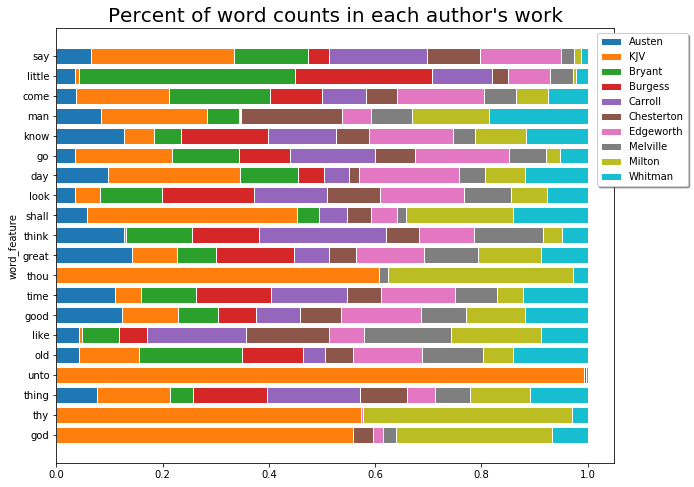

In [16]:
# Plot first 50 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 8))
for count, author in enumerate(authors):
    #plot use of words for given author
    plt.barh(wrd_pcts_l.index[:20], wrd_pcts_l[author][:20], 
             left=wrd_pcts_l[authors[:count]].sum(axis=1)[:20], 
             edgecolor='white', label=author)
    
ax.set_ylabel('word_feature')
ax.invert_yaxis()
ax.set_title("Percent of word counts in each author's work", fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(1.05, 1.0),#(1.00, 0),
          ncol=1, fancybox=True, shadow=True)
plt.show()

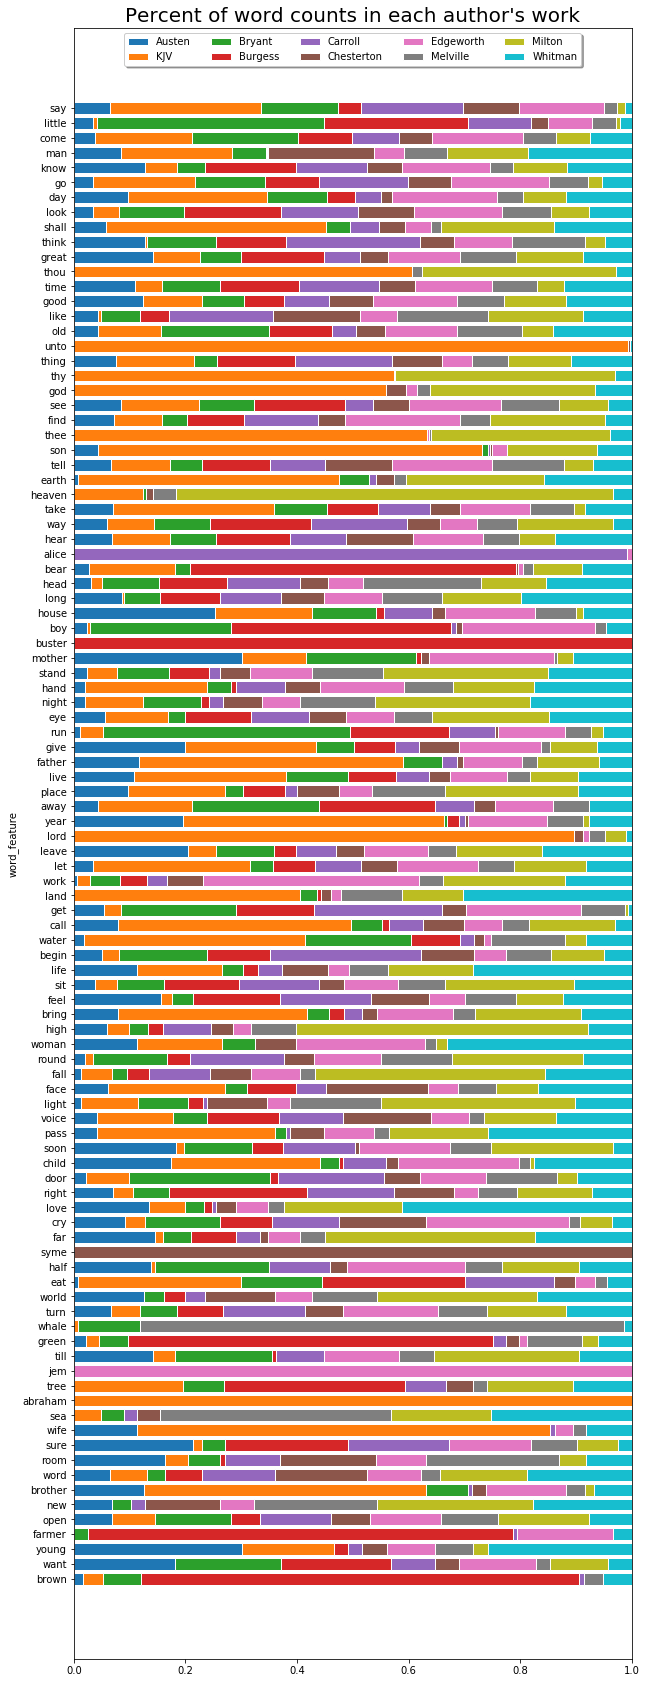

In [17]:
# Plot first 50 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 30))
for count, author in enumerate(authors):
    #plot use of words for given author
    plt.barh(wrd_pcts_l.index[:100], wrd_pcts_l[author][:100], 
             left=wrd_pcts_l[authors[:count]].sum(axis=1)[:100],
             edgecolor='white', label=author)
    
ax.set_ylabel('word_feature')
ax.invert_yaxis()
ax.set_title("Percent of word counts in each author's work", fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)
plt.show()

Looks like there are some tokens that have a pretty even occurrence across each author's texts. We'll have to come up with a method of removing as many of them as possible in order to increase the amount of information gain from each token. 

### Barplots of most frequent 50 tokens for each author

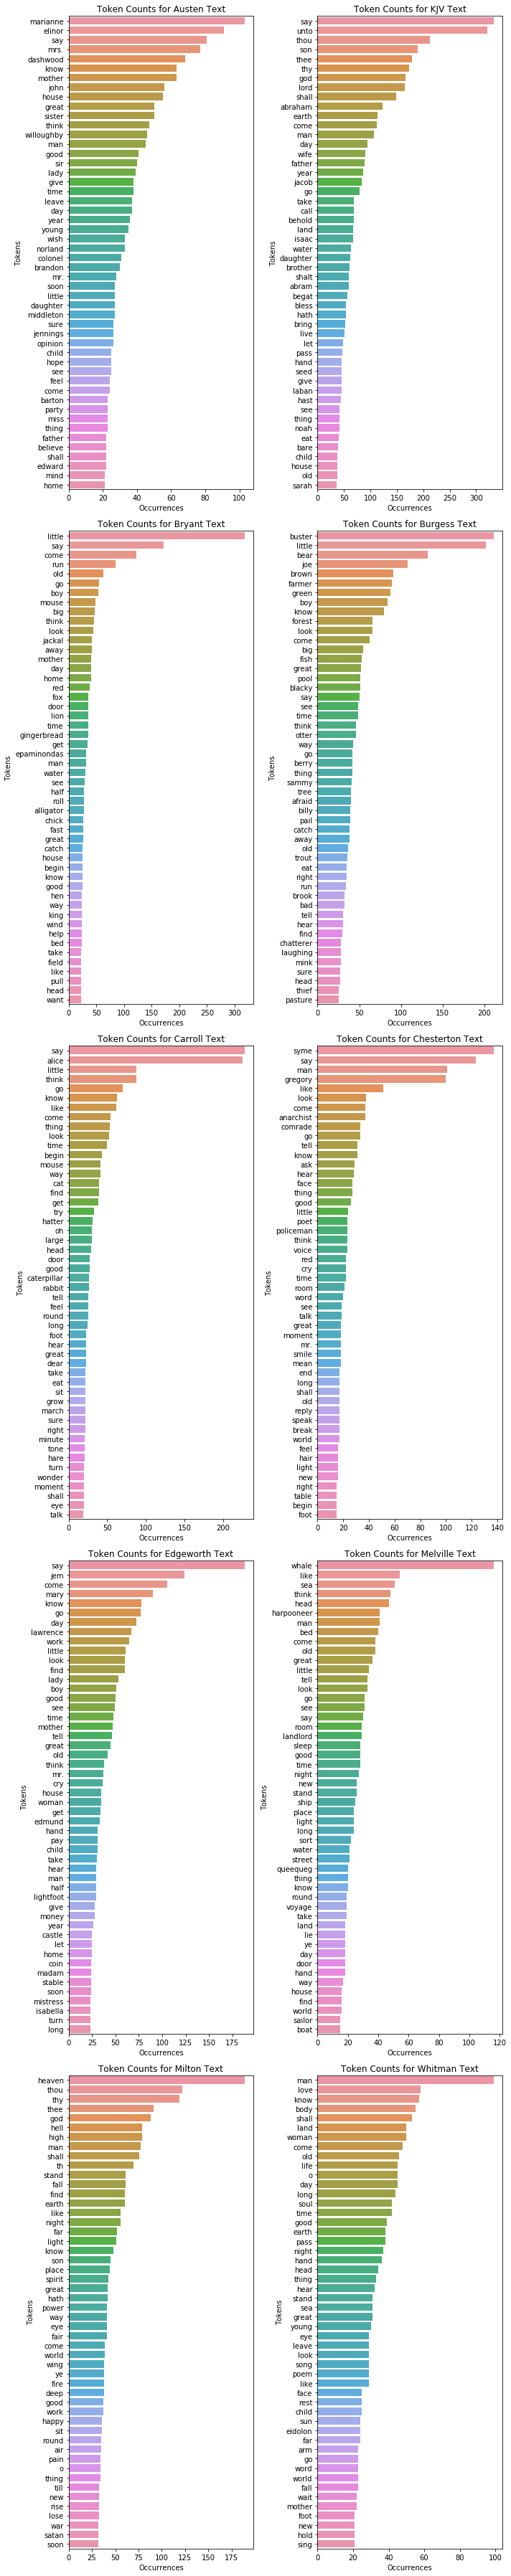

In [18]:
plt.figure(figsize=(10, 50))

for plot, author in enumerate(authors):
    data = word_cts_l.T[author].sort_values(ascending=False)[:50]
    plt.subplot(5, 2, plot+1)
    sns.barplot(y=data.index, x=data.values)
    plt.title('Token Counts for {} Text'.format(author))
    plt.ylabel('Tokens')
    plt.xlabel('Occurrences')

plt.tight_layout()    
plt.show()

Between the two sets of visualizations we can see there are many tokens that appear far too often between the texts to help us form distinct clusters. In order to get more performance out of a clustering model, we'll need to remove some of the very frequent words. Rather than doing so by visual analysis, we'll take a more methodical approach and try using the Gini Coefficient. 

The Gini Coefficient is often used in economics to measure the dispersion of wealth among a country's inhabitants. It can also be used to measure other types of data (in this case, frequency of word occurrence among authors). In our case, lower Gini scores will mean equal occurrence among all authors, and higher scores will mean one author is responsible for all uses of the word.

## Optimizing our BOW using Gini Coefficient

In [19]:
# With the Gini coefficient measure:
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2.
    return (fair_area - area) / fair_area

In [20]:
wrd_pcts_l['gini'] = wrd_pcts_l.drop('total', axis=1).apply(gini, axis=1)
wrd_pcts_l.tail()

text_authors,Austen,Bryant,Burgess,Carroll,Chesterton,Edgeworth,KJV,Melville,Milton,Whitman,total,gini
flee,0.0,0.0,0.05,0.00,0.00,0.00,0.5,0.00,0.45,0.00,20,0.79
curiosity,0.1,0.0,0.15,0.15,0.25,0.15,0.0,0.20,0.00,0.00,20,0.49
grandfather,0.0,0.0,1.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,20,0.90
grin,0.0,0.0,0.25,0.45,0.05,0.00,0.0,0.25,0.00,0.00,20,0.72
size,0.1,0.0,0.00,0.65,0.00,0.10,0.0,0.05,0.05,0.05,20,0.72


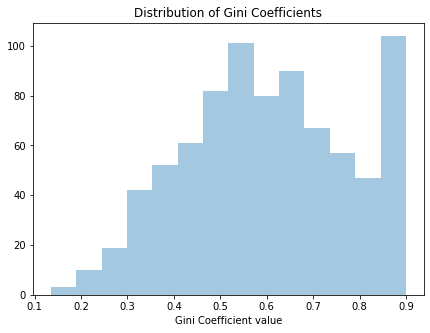

In [21]:
plt.figure(figsize=(7, 5))
sns.distplot(wrd_pcts_l.gini, kde=False)
plt.title('Distribution of Gini Coefficients')
plt.xlabel('Gini Coefficient value')
plt.show()

We're trying to capture the inequality side of our bag of words in hopes that we'll find more accurate predictors. It's encouraging that there are many values at the upper end of the plot. These will hopefully help our models in predicting accurately. We'll have to experiment a bit to see what a good cutoff point is.

We need to find a balance of words that are easy to distinguish, and keep enough to be able to predict, ideally, all of our dataset.

So, let's see what cutting off at a Gini coefficient value of 0.5 looks like.

In [22]:
gini_feats_l = wrd_pcts_l[wrd_pcts_l['gini'] > 0.5].index
len(gini_feats_l)

572

This seems like a good place to start. We'll be removing almost 250 features from our dataset.

In [23]:
# Create our new data set by removing the words with a Gini Coefficient below 0.5
#feats1 = large_feat_set
#feats2 = set(gini_feats_l)
removed_feats = [x for x in large_feat_set if x not in set(gini_feats_l)]
print("Number of features dropped:", len(removed_feats))

bow1 = large_bow_df.drop(removed_feats, axis=1).copy()
print("Shape of resulting dataset:", bow1.shape)

Number of features dropped: 243
Shape of resulting dataset: (10000, 575)


In [24]:
wrd_pcts_l = wrd_pcts_l.drop(removed_feats, axis=0).copy()
wrd_pcts_l.shape

(572, 12)

### Plot word use ratio by author

Let's repeat the same plot as above to look at what kind of use patterns we see. We're hoping to see a larger instance of concentrated use by one or a few authors.

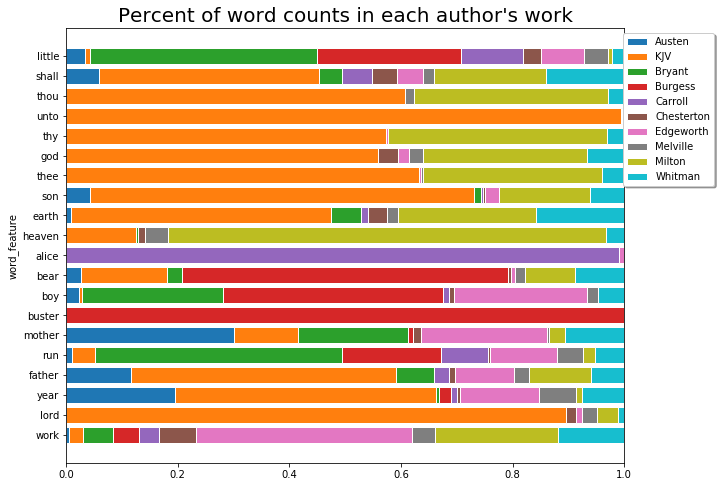

In [25]:
# Plot first 100 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 8))
for count, author in enumerate(authors):
    #plot use of words for given author
    plt.barh(wrd_pcts_l.index[:20], wrd_pcts_l[author][:20], 
             left=wrd_pcts_l[authors[:count]].sum(axis=1)[:20], 
             edgecolor='white', label=author)
    
ax.set_ylabel('word_feature')
ax.invert_yaxis()
ax.set_title("Percent of word counts in each author's work", fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(1.08, 1.0),
          ncol=1, fancybox=True, shadow=True)
plt.show()

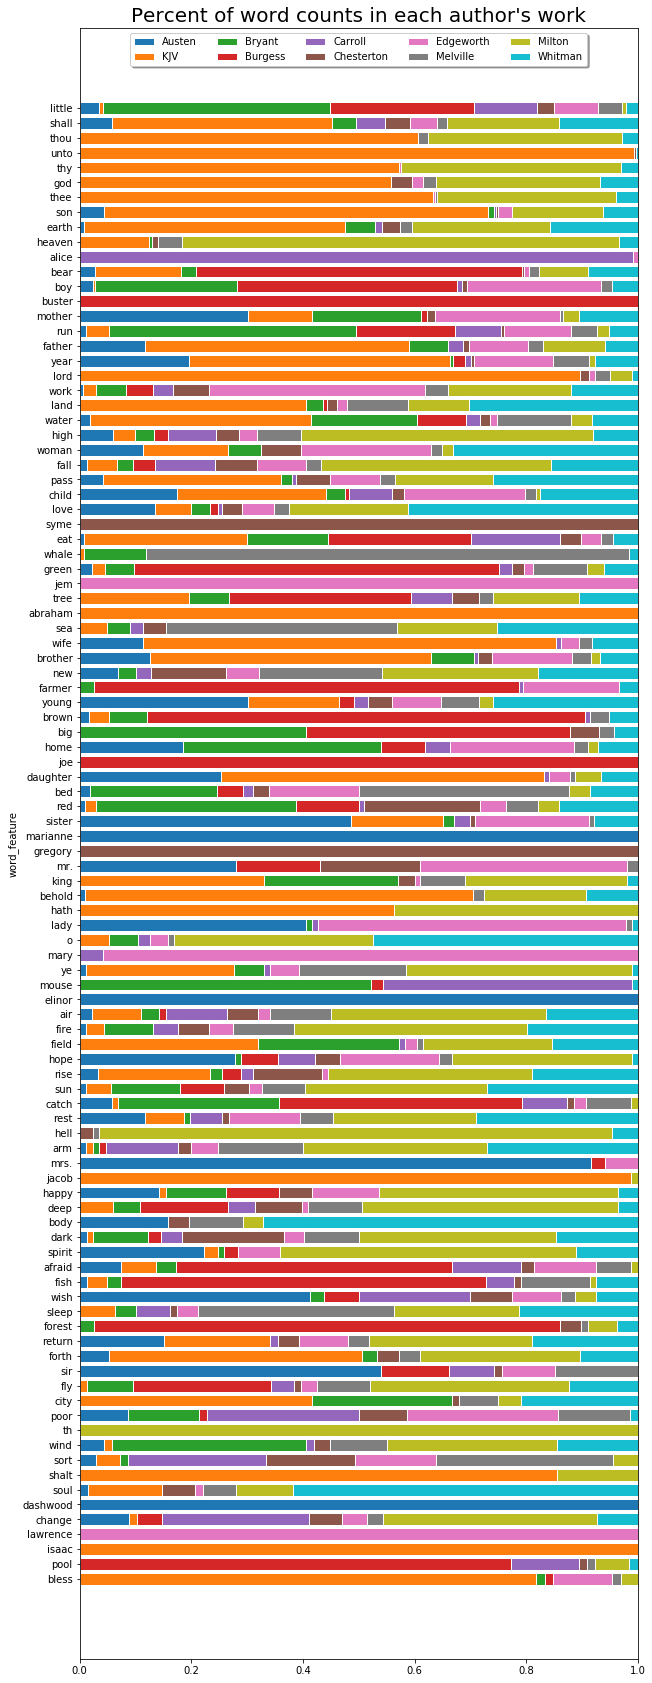

In [26]:
# Plot first 100 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 30))
for count, author in enumerate(authors):
    #plot use of words for given author
    plt.barh(wrd_pcts_l.index[:100], wrd_pcts_l[author][:100], 
             left=wrd_pcts_l[authors[:count]].sum(axis=1)[:100], 
             edgecolor='white', label=author)
    
ax.set_ylabel('word_feature')
ax.invert_yaxis()
ax.set_title("Percent of word counts in each author's work", fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)
plt.show()

This looks __much__ better than before! We see many bars that are dominated by one author, and even in the less clear cases, there's always at least one author that makes up a significant amount of the use.

Now let's run some clustering and see what our BOW can do!

## Unsupervised method: Clustering
Once we translate our Gini results into a new dataframe, we will start by creating a 75-25 train test split. From there we'll split our training clusters into 4 equal parts and try to find ideal cluster size with the Elbow Method. Then we'll move on to KMeans clustering using our ideal cluster size.

In [27]:
# Create X and y variables
Xs = bow1.drop(['text_authors', 'text_sentences', 'author_code'], axis=1)
Xs_norm = MinMaxScaler().fit_transform(Xs)
ys = bow1['author_code']

# Create train test split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_norm, ys, test_size=0.25, random_state=5588)

# Create 4 equal subsections of the training set to verify model consistency
pca = PCA(n_components=2)
Xs_pca = pca.fit_transform(Xs_train)

# First split in half, then halve each half
x1, x2, xpca1, xpca2 = train_test_split(Xs_train, Xs_pca, test_size=0.5, random_state=5588)
X1, X2, XPCA1, XPCA2 = train_test_split(x1, xpca1, test_size=0.5, random_state=5588)
X3, X4, XPCA3, XPCA4 = train_test_split(x2, xpca2, test_size=0.5, random_state=5588)

subsets = [X1, X2, X3, X4]

### Elbow Method

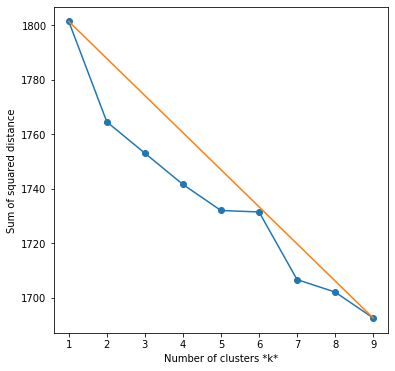

Optimal number of clusters: 2


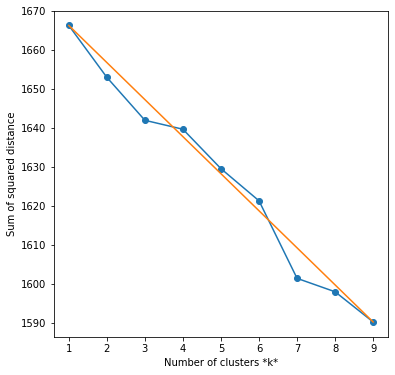

Optimal number of clusters: 7


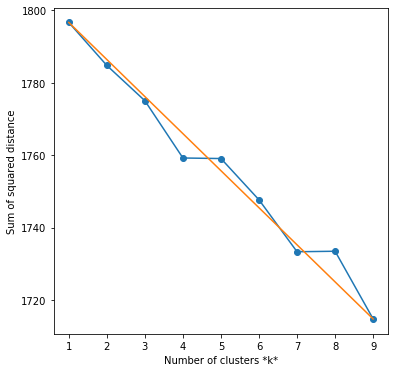

Optimal number of clusters: 8


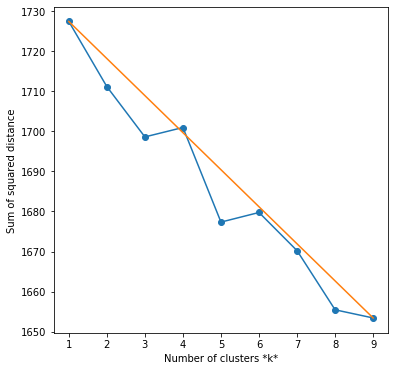

Optimal number of clusters: 5


In [28]:
# Run and plot elbow method analysis for each of the 4 subgroups
it = 1
K = range(1, 10)
for X in subsets:
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k, random_state=5588)
        km.fit(X)
        sse.append(km.inertia_)

    # Create coordinates for line segment to plot start point to end point
    x1, y1 = 1, sse[0]
    x2, y2 = 9, sse[-1]
    
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.plot((x1, x2), (y1, y2))
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');# Determine distortion for each value of k clusters
    plt.show()
    
    # Determing optimal cluster size, best balance between within-cluster homogeneity and 
    # cluster diversity by finding point furthest from straight line (x1, y1), (x2, y2)
    distances = []
    for i in range(len(sse)):
        x0 = i + 1
        y0 = sse[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2* x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distances.append(numerator/denominator)
    # Return best n_clusters value
    print('Optimal number of clusters:', distances.index(max(distances)) + 1)
    it += 1

Unfortunately, the elbow method wasn't able to provide a conclusive K best clusters. In order make a more informed choice, I'll run a silhouette coefficient analysis.

### Silhouette Coefficient

In [29]:
for cluster in range(2,9):
    print()
    print("{} clusters:".format(cluster))
    scores = []
    for sample in subsets:
        model = KMeans(n_clusters=cluster, random_state=5588).fit(sample)
        labels = model.labels_
        score = metrics.silhouette_score(sample, labels, metric='euclidean', random_state=5588)
        scores.append(score)
        print(score)
    print('mean_score:', np.mean(scores))


2 clusters:
0.8026279774827905
0.4090065268594245
0.3873572879573935
0.3349056286130473
mean_score: 0.48347435522816395

3 clusters:
0.34507222837051194
0.3608158970448532
0.2602259136437972
0.32055863930839973
mean_score: 0.3216681695918905

4 clusters:
0.37186484831207256
0.3146923614485302
0.285877135742337
0.3100515598889746
mean_score: 0.32062147634797855

5 clusters:
0.0012954326145238788
0.13890380195840218
0.22336967321859932
0.15775851514667
mean_score: 0.13033185573454886

6 clusters:
0.08104130195330023
0.4208110153097503
0.2289759027985252
0.10415045400892942
mean_score: 0.20874466851762627

7 clusters:
0.2786090852131974
0.29949885681629806
0.27222329897849074
0.1390049452486251
mean_score: 0.2473340465641528

8 clusters:
0.21994845168726668
0.31753346857114867
0.16181477662916693
0.1448553217948761
mean_score: 0.21103800467061457


The highest is definitely the 2-cluster model, though none of them are particularly strong. Let's move forward using a 2-cluster K-Means model and inspect some of the sentences to see if we can find any patterns.

### Run KMeans clustering model

In [30]:
kmean = KMeans(n_clusters=2, random_state=5588)
kmean.fit(Xs_train, ys_train)
y_preds = kmean.predict(Xs_test)
print(pd.crosstab(ys_test, y_preds))

col_0          0   1
author_code         
0            253   0
1            188  73
2            254   1
3            253   0
4            246   0
5            247   0
6            250   1
7            250   3
8            184  53
9            235   9


Right away, we're not seeing great results. Most of the test sentences remained in cluster 0, and cluster 1 is mostly made up of sentences from only two authors. Let's check in more detail.

#### Cluster 0 analysis

In [31]:
test_df = bow1.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 0
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==0) & 
                                        (test_df['author_code']==auth_idx)]['text_sentences']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Austen
But not so easily did Elinor recover from the alarm into which it had thrown her.

Austen
In showing kindness to his cousins therefore he had the real satisfaction of a good heart; and in settling a family of females only in his cottage, he had all the satisfaction of a sportsman; for a sportsman, though he esteems only those of his sex who are sportsmen likewise,

Austen
"That is to say," cried Marianne contemptuously, "he has told you, that in the East Indies the climate is hot, and the mosquitoes are troublesome."

Austen
In such employments as these they were interrupted soon after breakfast the next day by the entrance of their landlord, who called to welcome them to Barton, and to offer them every accommodation from his own house and garden in which theirs might at present be deficient.

Austen
She had an excellent heart;her disposition was affectionate, and her feelings were strong; but she knew how to govern them: it was a knowledge which her mother had yet to learn; and

There doesn't seem to be any trend in the above sentences.

#### Cluster 1 analysis

In [32]:
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==1) & 
                                        (test_df['author_code']==auth_idx)]['text_sentences']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

KJV
: God shall enlarge Japheth, and he shall dwell in the tents of Shem; and Canaan shall be his servant. :

KJV
: And his sons Isaac and Ishmael buried him in the cave of Machpelah, in the field of Ephron the son of Zohar the Hittite, which is before Mamre; : The field which Abraham purchased of the sons of Heth: there was Abraham buried, and Sarah his wife.

KJV
: Bring forth with thee every living thing that is with thee, of all flesh, both of fowl, and of cattle, and of every creeping thing that creepeth upon the earth; that they may breed abundantly in the earth, and be fruitful, and multiply upon the earth. :

KJV
: And, behold, I, even I, do bring a flood of waters upon the earth, to destroy all flesh, wherein is the breath of life, from under heaven; and every thing that is in the earth shall die.

KJV
Nay, my lord, hear me: the field give I thee, and the cave that is therein

KJV
: And the LORD said unto Cain, Why art thou wroth?

KJV
: And when the morning arose, then the an

Unfortunately there's nothing standing out that differentiates the two clusters. It looks like this BOW configuration isn't so great with clustering. We can try to use some supervised learning models to see how they use the feature set.

## Supervised Learning models
We'll use a few classification algorithms for the job: Logistic Regression, Linear Support Vector Classifier, and Random Forest Classifier.

### Logistic Regression

In [33]:
logreg = LogisticRegression(random_state=5588, solver='lbfgs', multi_class='auto')
accuracy = cross_val_score(logreg, Xs_train, ys_train, 
                           scoring='accuracy', cv=5)
print("CV scores:", accuracy)
print("Avg accuracy score:", np.mean(accuracy))

CV scores: [0.56781915 0.56819694 0.54733333 0.56608812 0.55785953]
Avg accuracy score: 0.5614594141972981


Logistic Regression model accuracy on test set: 0.5528



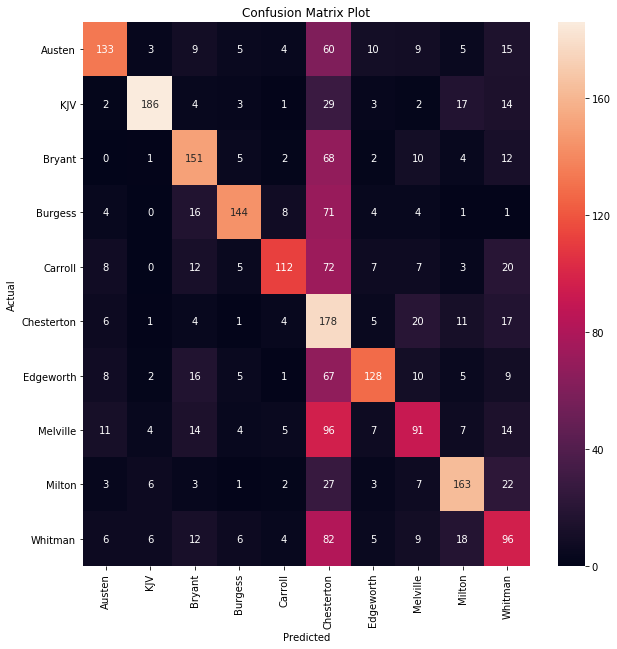

In [34]:
logreg.fit(Xs_train, ys_train)
logreg_pred = logreg.predict(Xs_test)

print("Logistic Regression model accuracy on test set:", metrics.accuracy_score(ys_test, logreg_pred))
print()

confmat = metrics.confusion_matrix(ys_test, logreg_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confmat, annot=True, fmt='d', xticklabels=authors,
           yticklabels=authors)
plt.title("Confusion Matrix Plot")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### LinearSVC

In [35]:
LSVC = LinearSVC()
accuracy = cross_val_score(LSVC, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.56582447 0.56021291 0.548      0.5694259  0.56120401]
Avg accuracy score: 0.5609334580365863


Linear SVC accuracy score on test set: 0.56



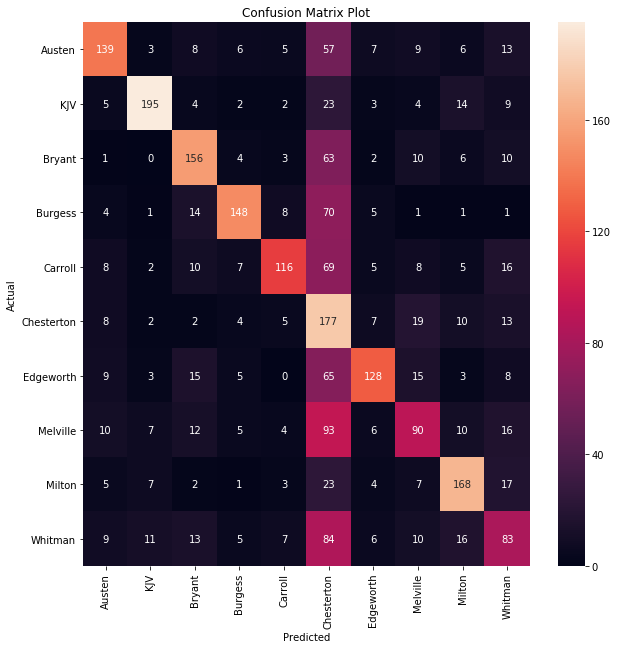

In [36]:
LSVC.fit(Xs_train, ys_train)
LSVC_pred = LSVC.predict(Xs_test)

print("Linear SVC accuracy score on test set:", metrics.accuracy_score(ys_test, LSVC_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, LSVC_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.title("Confusion Matrix Plot")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier

In [37]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=5588)
accuracy = cross_val_score(forest, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.40957447 0.4324684  0.41666667 0.42456609 0.42541806]
Avg accuracy score: 0.4217387359220369


Random Forest accuracy on test set: 0.4316



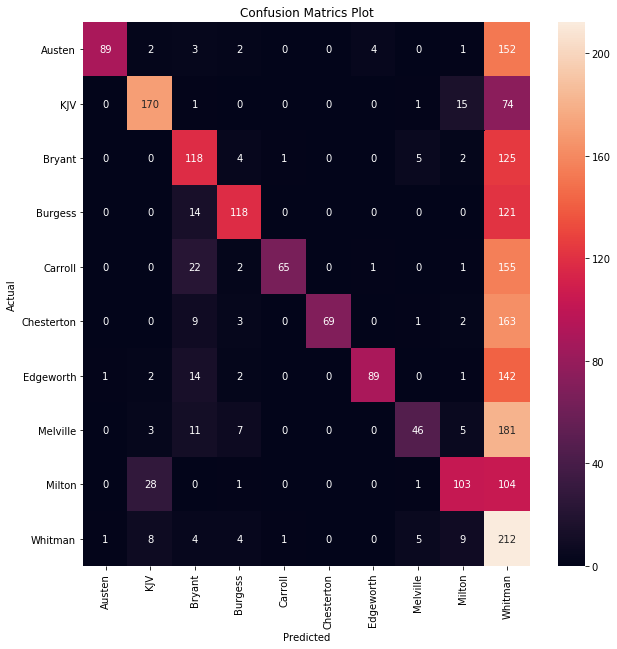

In [38]:
forest.fit(Xs_train, ys_train)
forest_pred = forest.predict(Xs_test)

print("Random Forest accuracy on test set:", metrics.accuracy_score(ys_test, forest_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, forest_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.title("Confusion Matrics Plot")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

So, with our initial BOW, we weren't able to find any useful clustering, but we got pretty decent results from the supervised models, especially the Linear SVC and Logistic Regression models, which scored .56 and .55 on test set prediction, respectively.

# Analysis of smaller BOW feature set

Let's take a more extreme approach to our Gini Coefficient filtering and shoot for a subset of data around 300 or so.

## Clustering model with BOW features

Let's start out by looking at the dataframe, grouping by author. We'll want to look at this data with some graphs as well. We can check out the top words used per author, as well as the distribution of who is using the most common words.

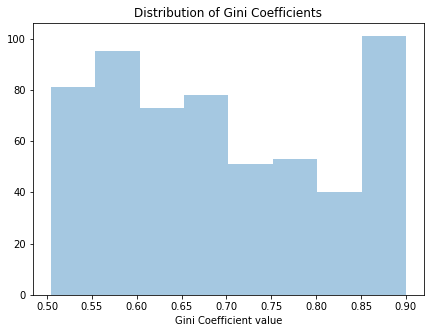

In [40]:
plt.figure(figsize=(7, 5))
sns.distplot(wrd_pcts_l.gini, kde=False)
plt.title('Distribution of Gini Coefficients')
plt.xlabel('Gini Coefficient value')
plt.show()

In [41]:
gini_feats_s = wrd_pcts_l[wrd_pcts_l['gini'] > 0.65].index
len(gini_feats_s)

326

In [42]:
# Create our new data set by removing the words with a Gini Coefficient below 0.5
#feats1 = large_feat_set
#feats2 = set(gini_feats_l)
removed_feats = [x for x in large_feat_set if x not in set(gini_feats_s)]
print("Number of features dropped:", len(removed_feats))

bow2 = large_bow_df.drop(removed_feats, axis=1).copy()
print("Shape of resulting dataset:", bow2.shape)

Number of features dropped: 489
Shape of resulting dataset: (10000, 329)


In [43]:
word_cts = bow2.groupby('text_authors').sum()
word_cts.drop('author_code', axis=1, inplace=True)
word_cts.loc['total'] = word_cts.sum()
word_cts.sort_values(by='total', axis=1, ascending=False, inplace=True)
word_cts

,thou,unto,thy,god,thee,son,earth,heaven,alice,bear,...,puzzle,bread,grin,wherefore,coast,canaan,dread,yield,grandfather,mankind
text_authors,,,,,,,,,,,,,,,,,,,,,
Austen,0,0,0,0,0,12,2,0,0,6,...,1,0,0,0,0,0,0,0,0,0
Bryant,0,0,0,0,0,3,13,1,0,6,...,0,7,0,0,0,0,0,0,0,0
Burgess,0,0,0,0,0,0,0,0,0,132,...,6,0,5,0,0,0,0,0,20,0
Carroll,0,0,0,0,0,1,3,0,225,0,...,7,2,9,0,1,0,0,0,0,0
Chesterton,0,1,0,11,0,1,8,3,0,1,...,0,0,1,0,0,0,0,0,0,5
Edgeworth,0,0,1,6,1,7,0,0,2,2,...,0,2,0,0,0,0,2,0,0,0
KJV,213,321,173,167,179,190,113,30,0,35,...,0,8,0,10,0,19,1,6,0,0
Melville,6,0,0,7,1,0,5,10,0,4,...,2,1,5,2,6,1,2,1,0,1
Milton,122,0,119,88,91,45,60,189,0,20,...,0,0,0,8,10,0,15,11,0,12


In [44]:
wrd_pcts = word_cts.T
for author in authors:
    wrd_pcts[author] = wrd_pcts[author] / wrd_pcts.total
wrd_pcts.head()

text_authors,Austen,Bryant,Burgess,Carroll,Chesterton,Edgeworth,KJV,Melville,Milton,Whitman,total
thou,0.0,0.0,0.0,0.0,0.000000,0.000000,0.606838,0.017094,0.347578,0.028490,351
unto,0.0,0.0,0.0,0.0,0.003096,0.000000,0.993808,0.000000,0.000000,0.003096,323
thy,0.0,0.0,0.0,0.0,0.000000,0.003311,0.572848,0.000000,0.394040,0.029801,302
god,0.0,0.0,0.0,0.0,0.036789,0.020067,0.558528,0.023411,0.294314,0.066890,299
thee,0.0,0.0,0.0,0.0,0.000000,0.003534,0.632509,0.003534,0.321555,0.038869,283


### Normalized plots of top 100 most frequent words, color-coded by author

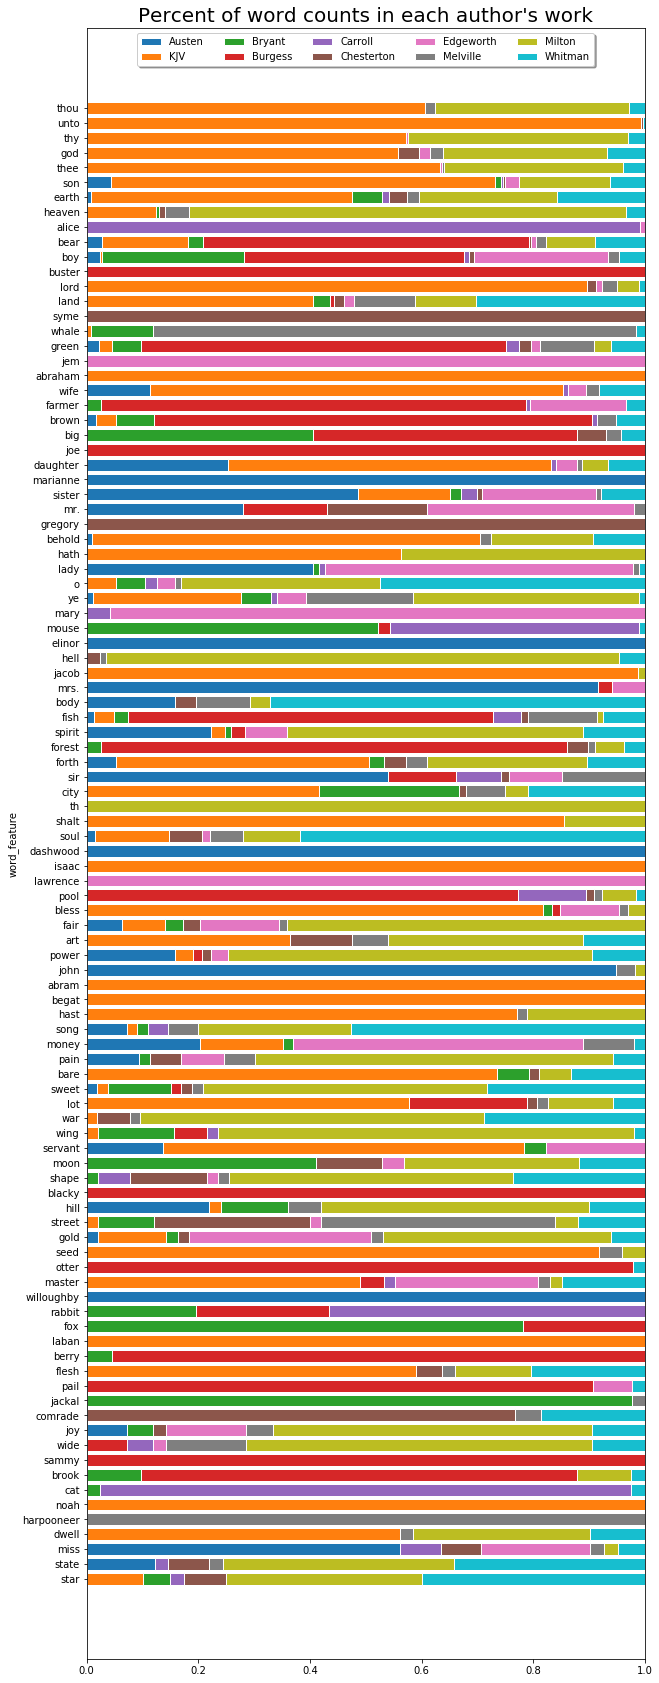

In [45]:
# Plot first 50 most occurring words in BOW
fig, ax = plt.subplots(figsize=(10, 30))
for count, author in enumerate(authors):
    #plot use of words for given author
    plt.barh(wrd_pcts.index[:100], wrd_pcts[author][:100], 
             left=wrd_pcts[authors[:count]].sum(axis=1)[:100], 
             edgecolor='white', label=author)
    
ax.set_ylabel('word_feature')
ax.invert_yaxis()
ax.set_title("Percent of word counts in each author's work", fontsize=20)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00),
          ncol=5, fancybox=True, shadow=True)
plt.show()

The features of this BOW are looking a lot more promising, as far as being better predictors of an author. 

### Barplots of most frequent 50 words for each author

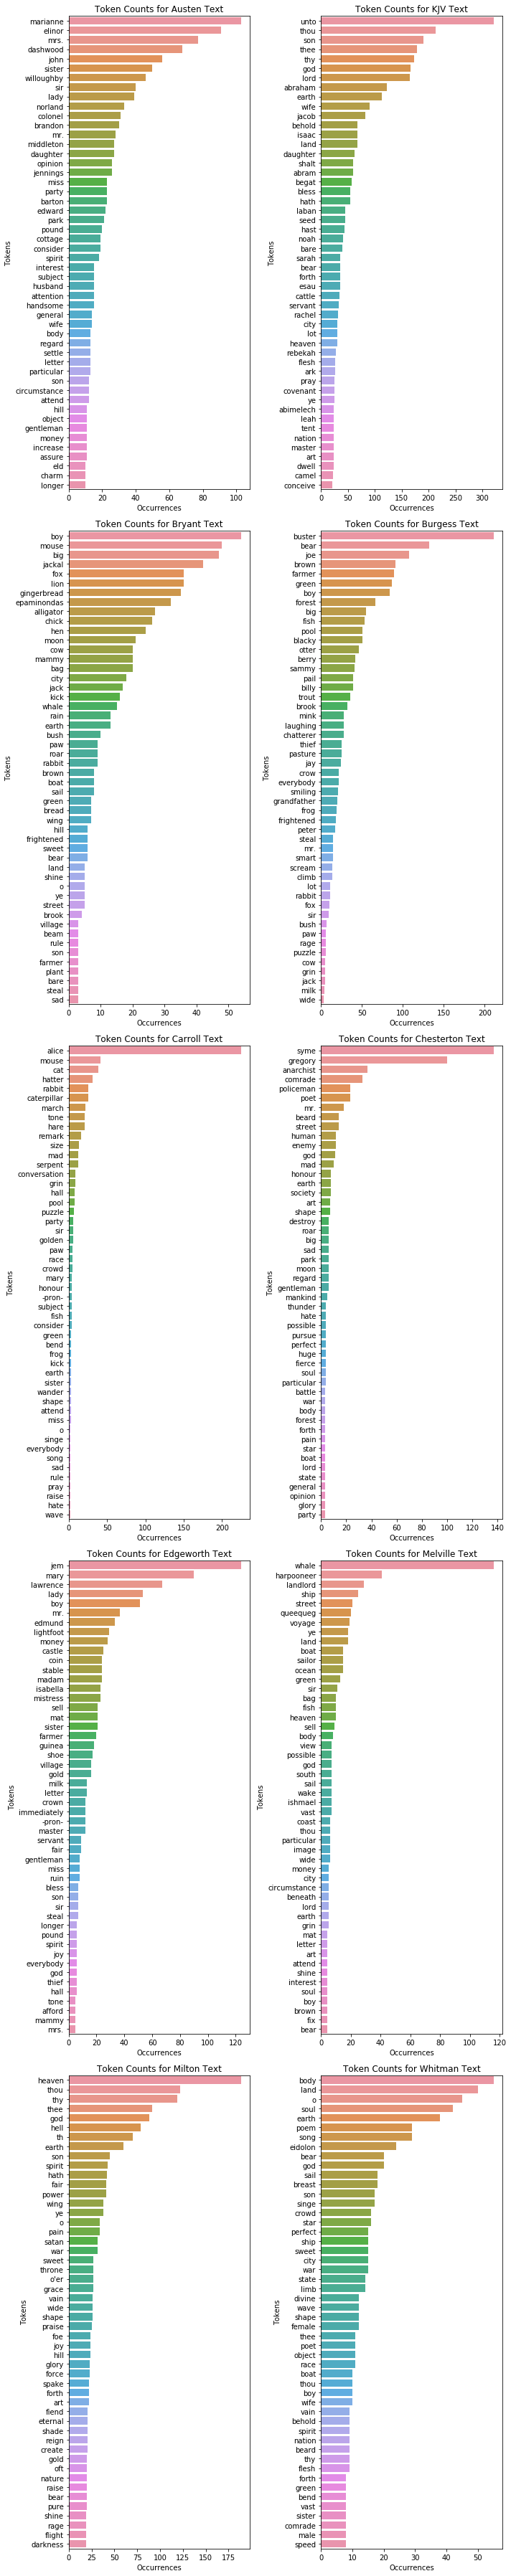

In [46]:
plt.figure(figsize=(10, 50))

for plot, author in enumerate(authors):
    data = word_cts.T[author].sort_values(ascending=False)[:50]
    plt.subplot(5, 2, plot+1)
    sns.barplot(y=data.index, x=data.values)
    plt.title('Token Counts for {} Text'.format(author))
    plt.ylabel('Tokens')
    plt.xlabel('Occurrences')

plt.tight_layout()    
plt.show()

Much less overlap of terms, especially in the top 10 of each author. Let's move on to clustering these features and see how a more drastic approach to feature selection changes our results.

## Clustering

### Finding ideal cluster size with Elbow Method

In [47]:
# Create X and y variables
Xs = bow2.drop(['text_authors', 'text_sentences', 'author_code'], axis=1)
Xs_norm = MinMaxScaler().fit_transform(Xs)
ys = bow2['author_code']

# Create train test split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_norm, ys, test_size=0.25, random_state=5588)

# Create 4 equal subsections of the training set to verify model consistency
pca = PCA(n_components=2)
Xs_pca = pca.fit_transform(Xs_train)

# First split in half, then halve each half
x1, x2, xpca1, xpca2 = train_test_split(Xs_train, Xs_pca, test_size=0.5, random_state=5588)
X1, X2, XPCA1, XPCA2 = train_test_split(x1, xpca1, test_size=0.5, random_state=5588)
X3, X4, XPCA3, XPCA4 = train_test_split(x2, xpca2, test_size=0.5, random_state=5588)

subsets = [X1, X2, X3, X4]

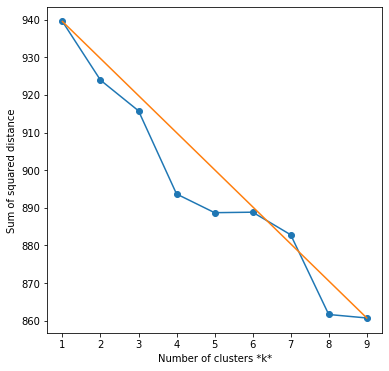

Optimal number of clusters: 4


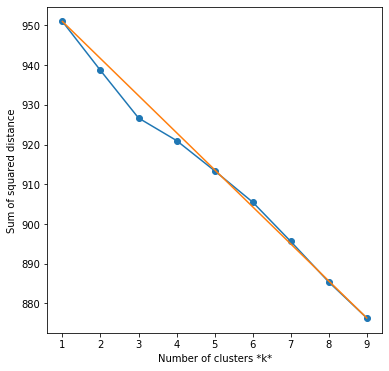

Optimal number of clusters: 3


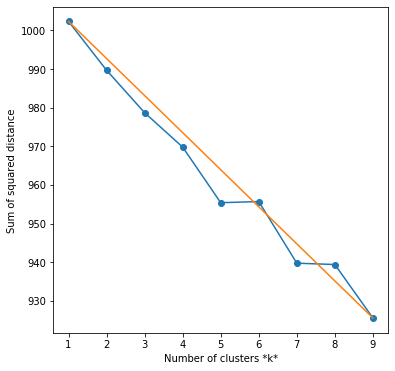

Optimal number of clusters: 5


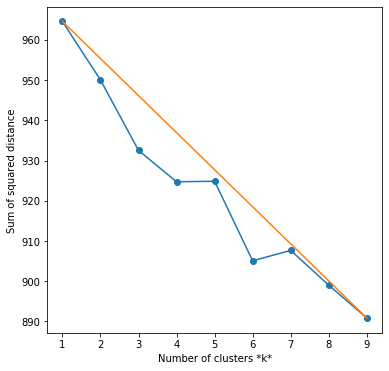

Optimal number of clusters: 3


In [48]:
# Run and plot elbow method analysis for each of the 4 subgroups
it = 1
K = range(1, 10)
for X in subsets:
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k, random_state=5588)
        km.fit(X)
        sse.append(km.inertia_)

    # Create coordinates for line segment to plot start point to end point
    x1, y1 = 1, sse[0]
    x2, y2 = 9, sse[-1]
    
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.plot((x1, x2), (y1, y2))
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');# Determine distortion for each value of k clusters
    plt.show()
    
    # Determing optimal cluster size, best balance between within-cluster homogeneity and 
    # cluster diversity by finding point furthest from straight line (x1, y1), (x2, y2)
    distances = []
    for i in range(len(sse)):
        x0 = i + 1
        y0 = sse[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2* x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distances.append(numerator/denominator)
    # Return best n_clusters value
    print('Optimal number of clusters:', distances.index(max(distances)) + 1)
    it += 1

Looks like a 3 cluster model is ideal here, so let's go ahead and make our K-Means model.

### K-Means clustering analysis

In [49]:
kmean = KMeans(n_clusters=3, random_state=5588)
kmean.fit(Xs_train, ys_train)
y_preds = kmean.predict(Xs_test)
print(pd.crosstab(ys_test, y_preds))

col_0         0    1   2
author_code             
0            11  242   0
1             0  222  39
2             0  255   0
3             0  253   0
4             0  246   0
5             0  247   0
6             0  250   1
7             0  252   1
8             0  236   1
9             0  244   0


Our cluster sizes are again not looking so good. We can visually inspect sentences to see if we uncover any patterns, but we really want a more complete separation of authors into difference clusters.

I'm only going to inspect clusters 0 and 2 because 1 is likely without a rule, just a catchall for everything else.

#### Cluster 0 analysis

In [50]:
test_df = bow2.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==0) & 
                                        (test_df['author_code']==auth_idx)]['text_sentences']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Austen
She was remarkably quick in the discovery of attachments, and had enjoyed the advantage of raising the blushes and the vanity of many a young lady by insinuations of her power over such a young man; and this kind of discernment enabled her soon after her arrival at Barton decisively to pronounce that Colonel Brandon was very much in love with Marianne Dashwood.

Austen
You will be setting your cap at him now, and never think of poor Brandon."

Austen
Mrs. Dashwood, who could not think a man five years younger than herself, so exceedingly ancient as he appeared to the youthful fancy of her daughter, ventured to clear Mrs. Jennings from the probability of wishing to throw ridicule on his age. "

Austen
Colonel Brandon is certainly younger than Mrs. Jennings, but he is old enough to be MY father; and if he were ever animated enough to be in love, must have long outlived every sensation of the kind.

Austen
Colonel Brandon, the friend of Sir John, seemed no more adapted by resemblan

The cluster certainly captures the use of 'colonel','brandon', and 'jennings'.  

In [51]:
print("sentences containing the lemma colonel:", test_df.loc[:, 'colonel'].sum())
print("sentences containing the lemma brandon:", test_df.loc[:, 'brandon'].sum())
print("sentences containing the lemma jennings:", test_df.loc[:, 'jennings'].sum())
print("sentences in cluster 0:", test_df[test_df['cluster']==0].shape[0])

sentences containing the lemma colonel: 6
sentences containing the lemma brandon: 6
sentences containing the lemma jennings: 6
sentences in cluster 0: 11


There is overlap of the words between the sentences above. It appears they have combined to predict these 11 sentences. Not very helpful.

#### Cluster 2 analysis

In [52]:
test_df = bow2.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==2) & 
                                        (test_df['author_code']==auth_idx)]['text_sentences']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

KJV
: And his sons Isaac and Ishmael buried him in the cave of Machpelah, in the field of Ephron the son of Zohar the Hittite, which is before Mamre; : The field which Abraham purchased of the sons of Heth: there was Abraham buried, and Sarah his wife.

KJV
Nay, my lord, hear me: the field give I thee, and the cave that is therein

KJV
: And the LORD said unto Cain, Why art thou wroth?

KJV
: So the LORD scattered them abroad from thence upon the face of all the earth: and they left off to build the city.

KJV
: And the LORD said unto Cain, Where is Abel thy brother?

KJV
: And the LORD said unto Noah, Come thou and all thy house into the ark; for thee have I seen righteous before me in this generation.

KJV
: And it came to pass at that time, that Abimelech and Phichol the chief captain of his host spake unto Abraham, saying, God is with thee in all that thou doest: : Now therefore swear unto me here by God that thou wilt not deal falsely with me, nor with my son, nor with my son's so

I'm seeing a lot of the lemma "lord," let's investigate that a bit more.

In [53]:
print("sentences containing the lemma lord:", test_df.loc[:, 'lord'].sum())
print("sentences in cluster 3:", test_df[test_df['cluster']==2].shape[0])

sentences containing the lemma lord: 38
sentences in cluster 3: 42


Most of the sentences in cluster 3 are explained by the 'lord' column.

Even when we culled nearly 500 features and worked with only the most predictive 300, clustering proved fairly useless. Below we'll see if this dataset performs any better with the supervised models.

First, just for the sake of experimentation, I'd like to try a 10 cluster model to see if by chance it magically determines the 10 authors.

### K-Mean 10 cluster model

In [54]:
kmean = KMeans(n_clusters=10, random_state=5588)
kmean.fit(Xs_train, ys_train)
y_preds = kmean.predict(Xs_test)
print(pd.crosstab(ys_test, y_preds))

col_0         0  1  2  3  4   5  6   7  8    9
author_code                                   
0             0  1  1  0  0   0  0   0  0  251
1             0  0  0  0  7  48  1   0  0  205
2             0  0  0  0  0   0  1   0  0  254
3            37  0  0  7  0   0  0   0  0  209
4             0  2  0  0  0   0  1  46  4  193
5             0  2  1  0  0   0  0   0  0  244
6             0  0  0  0  0   1  0   0  0  250
7             0  1  0  0  0   1  0   0  0  251
8             0  3  3  0  5   1  6   0  0  219
9             0  0  0  0  0   0  0   0  1  243


It's not looking any better than our previous results, so I won't bother going deeper into analysis. Let's move on to the supervised models.

## Supervised modeling of small BOW

### Logistic Regression

In [55]:
logreg = LogisticRegression(random_state=5588, solver='lbfgs', multi_class='auto')
accuracy = cross_val_score(logreg, Xs_train, ys_train, 
                           scoring='accuracy', cv=5)
print("CV scores:", accuracy)
print("Avg accuracy score:", np.mean(accuracy))

CV scores: [0.52393617 0.52029275 0.49933333 0.52069426 0.5083612 ]
Avg accuracy score: 0.5145235428818303


Logistic Regression model accuracy on test set: 0.51



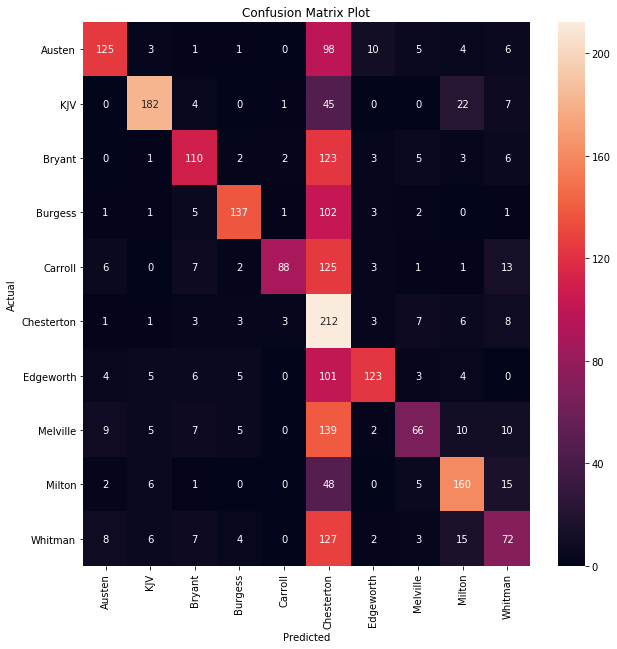

In [56]:
logreg.fit(Xs_train, ys_train)
logreg_pred = logreg.predict(Xs_test)

print("Logistic Regression model accuracy on test set:", metrics.accuracy_score(ys_test, logreg_pred))
print()

confmat = metrics.confusion_matrix(ys_test, logreg_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(confmat, annot=True, fmt='d', xticklabels=authors,
           yticklabels=authors)
plt.title("Confusion Matrix Plot")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### LinearSVC

In [57]:
LSVC = LinearSVC()
accuracy = cross_val_score(LSVC, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.53125    0.52694611 0.50466667 0.52736983 0.50635452]
Avg accuracy score: 0.5193174231873025


Linear SVC accuracy score on test set: 0.5136



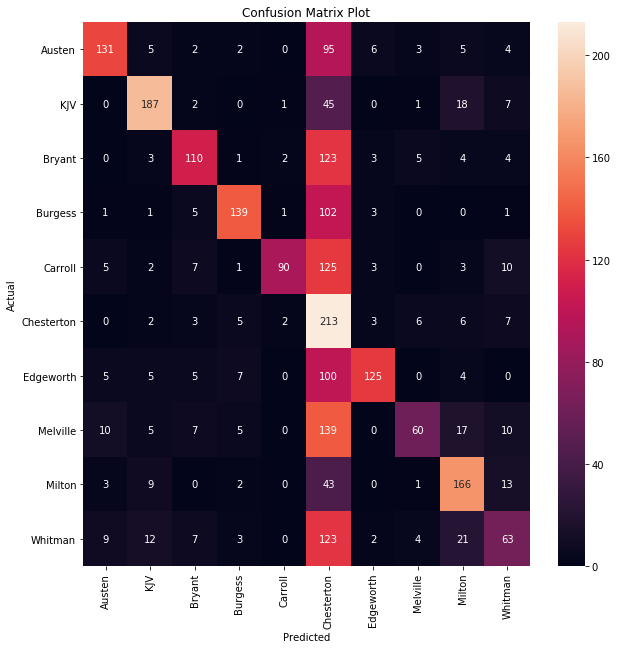

In [58]:
LSVC.fit(Xs_train, ys_train)
LSVC_pred = LSVC.predict(Xs_test)

print("Linear SVC accuracy score on test set:", metrics.accuracy_score(ys_test, LSVC_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, LSVC_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.title("Confusion Matrix Plot")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier

In [59]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=5588)
accuracy = cross_val_score(forest, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.39162234 0.39986693 0.378      0.39052069 0.39598662]
Avg accuracy score: 0.39119931791183743


Random Forest accuracy on test set: 0.4064



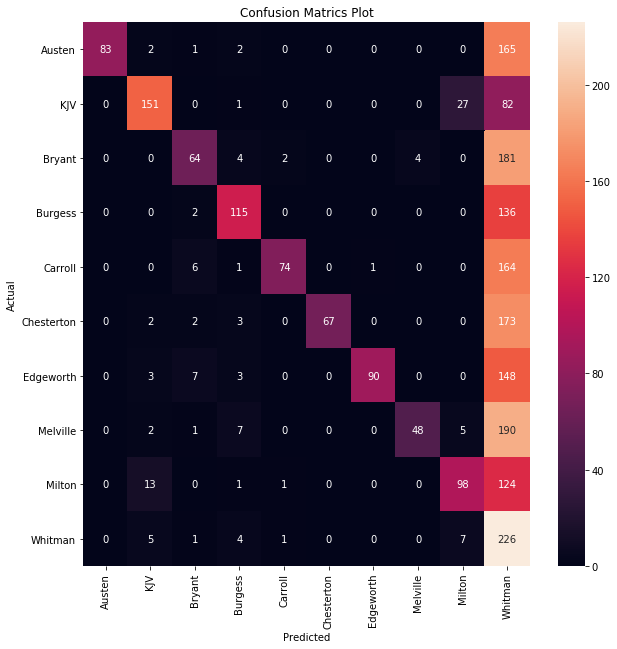

In [60]:
forest.fit(Xs_train, ys_train)
forest_pred = forest.predict(Xs_test)

print("Random Forest accuracy on test set:", metrics.accuracy_score(ys_test, forest_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, forest_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.title("Confusion Matrics Plot")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

It appears that we may have gone too far in removing so many features. At least for our supervised models, they performed worse than with the previous BOW.

Instead of further tinkering with our BOW approach, let's move on to tfidf and see if there's any improvement.

# tfidf feature selection

Let's start by lightly processing our sentences, this time we won't remove any chapter headings, numbers, or characters/symbols (except '--').

## Text preprocessing

In [61]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [62]:
### Assign variables for all texts
sense_sent = gutenberg.sents('austen-sense.txt')
bible_sent = gutenberg.sents('bible-kjv.txt')
stories_sent = gutenberg.sents('bryant-stories.txt')
buster_sent = gutenberg.sents('burgess-busterbrown.txt')
alice_sent = gutenberg.sents('carroll-alice.txt')
thursday_sent = gutenberg.sents('chesterton-thursday.txt')
parents_sent = gutenberg.sents('edgeworth-parents.txt')
moby_sent = gutenberg.sents('melville-moby_dick.txt')
paradise_sent = gutenberg.sents('milton-paradise.txt')
leaves_sent = gutenberg.sents('whitman-leaves.txt')

texts = [sense_sent, bible_sent, stories_sent, buster_sent, alice_sent, thursday_sent,
        parents_sent, moby_sent, paradise_sent, leaves_sent]

tfidf_sents = []
for text in texts:
    for idx, sent in enumerate(text):
        if idx <1000:
            sent=[re.sub('--', '', word) for word in sent]
            #tfidf_sents.append(sent)
            tfidf_sents.append(' '.join(sent))
            
print(tfidf_sents[:4])
#print(len(tfidf_sents))

['[ Sense and Sensibility by Jane Austen 1811 ]', 'CHAPTER 1', 'The family of Dashwood had long been settled in Sussex .', 'Their estate was large , and their residence was at Norland Park , in the centre of their property , where , for many generations , they had lived in so respectable a manner as to engage the general good opinion of their surrounding acquaintance .']


In [63]:
sent_df2 = pd.DataFrame()
sent_df2['text_sent'] = tfidf_sents
sent_df2[['author', 'author_code']] = sentences_df[['author', 'author_code']]
sent_df2.head()

,text_sent,author,author_code
0,[ Sense and Sensibility by Jane Austen 1811 ],Austen,0
1,CHAPTER 1,Austen,0
2,The family of Dashwood had long been settled i...,Austen,0
3,"Their estate was large , and their residence w...",Austen,0
4,The late owner of this estate was a single man...,Austen,0


## Perform feature selection with TfidfVectorizer 

In [64]:
X_train, X_test = train_test_split(tfidf_sents, test_size=0.25, random_state=5588)

vectorizer = TfidfVectorizer(max_df=0.5,
                             min_df=2,
                             stop_words='english', 
                             lowercase=True,
                             use_idf=True,
                             norm=u'l2', 
                             smooth_idf=True
                            )


#Applying the vectorizer
sents_tfidf=vectorizer.fit_transform(tfidf_sents)
print("Number of features: %d" % sents_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(sents_tfidf, test_size=0.25, random_state=5588)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bysent = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bysent[i][terms[j]] = X_train_tfidf_csr[i, j]

print('Original sentence:', X_train[3])
print()
print('Tf_idf vector:', tfidf_bysent[3])

Number of features: 8200
Original sentence: The kind villagers left their work and ran to the field to help him .

Tf_idf vector: {'villagers': 0.5198661514401983, 'field': 0.3545941239924739, 'work': 0.32879247478185786, 'ran': 0.34933493822591, 'help': 0.36769026466090876, 'kind': 0.35079145465695943, 'left': 0.3400176846746842}


In [65]:
tfidf_df = pd.DataFrame(tfidf_bysent)
tfidf_df.replace(np.nan, 0, inplace=True)
tfidf_df.head()

,terrible,tossing,impatiently,alice,turning,queen,went,head,said,child,...,deluge,quilt,slouched,pad,lily,crush,source,hillside,scorning,responsive
0,1.0,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.445844,0.4555,0.248963,0.36619,0.36619,0.241199,0.264557,0.165783,0.32851,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Feature dimensionality reduction using TruncatedSVD

We definitely need to reduce that feature space! 8013 is way too big, maybe something more like 500 would be better. We'll use 

In [66]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 8013 to 500.
svd= TruncatedSVD(500, random_state=5588)
lsa = make_pipeline(svd, Normalizer(copy=False))
# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

Percent variance captured by all components: 46.51086603609237


In [67]:
sents_by_component=pd.DataFrame(X_train_lsa,index=X_train)
sents_by_component.reset_index(inplace=True)
sents_by_component = sents_by_component.rename(columns={'index':'text_sent'})
sents_by_component.columns = sents_by_component.columns.map(str)

In [68]:
# Merge with dataframe of sentences, authors, and author codes
sents_by_component = sents_by_component.merge(sent_df2, on='text_sent')

In [69]:
sents_by_component.head()

,text_sent,0,1,2,3,4,5,6,7,8,...,492,493,494,495,496,497,498,499,author,author_code
0,He was very terrible to see .,0.003760,0.007333,0.001671,0.001801,-0.000859,-0.002192,-0.001354,-0.009892,-0.003249,...,0.016276,-0.000432,0.009982,-0.003284,0.013806,-0.043716,0.016429,-0.022747,Burgess,3
1,"said the Queen , tossing her head impatiently ...",0.286350,-0.059161,-0.062233,0.057856,-0.040321,-0.034326,-0.025159,-0.172703,-0.015022,...,0.023772,0.016213,-0.007907,0.007971,0.004901,-0.040013,-0.012031,0.000565,Carroll,4
2,"34 : 18 And their words pleased Hamor , and Sh...",0.031497,0.021383,0.085135,-0.017866,0.016128,0.006098,-0.018355,-0.013184,-0.032716,...,0.008696,0.005119,-0.001187,0.006827,-0.018955,0.027489,0.048883,0.026227,KJV,1
3,The kind villagers left their work and ran to ...,0.037996,0.064626,0.012195,0.020012,0.013701,-0.021030,0.029385,-0.048721,-0.033164,...,-0.009877,-0.008922,0.022710,-0.006095,-0.021104,-0.021066,0.015611,0.002382,Bryant,2
4,' What a curious feeling !',0.004219,0.014566,0.000186,0.009079,-0.012806,0.008453,-0.004622,-0.007275,0.002561,...,-0.009175,-0.015736,-0.045937,-0.007502,-0.027840,0.028070,-0.019109,0.015925,Carroll,4


In [70]:
component_cts = sents_by_component.groupby('author').sum()
component_cts.drop('author_code', axis=1, inplace=True)
component_cts.loc['total'] = component_cts.sum(axis=0)
component_cts.sort_values(by='total', axis=1, ascending=False, inplace=True)
component_cts

,0,1,3,2,32,48,79,13,31,50,...,62,52,19,41,38,17,12,9,16,7
author,,,,,,,,,,,,,,,,,,,,,
Austen,40.890989,30.238604,51.479834,7.959063,12.455287,3.253845,-6.672976,14.434225,-4.426896,-4.867626,...,1.563984,6.379707,-4.857791,-32.319974,-22.757792,-9.596315,15.477222,-17.294490,-15.446503,-20.207161
Bryant,112.364275,67.015883,-8.166962,-38.895751,11.754755,-10.950333,7.050442,-4.941289,7.340186,1.472937,...,-10.635802,-0.897757,6.296497,12.908807,1.142869,-3.871584,-53.372789,-31.554886,-22.116289,-9.430806
Burgess,43.145888,89.271056,11.775437,-31.298360,-1.265261,-6.248789,0.188931,2.402601,7.828148,-1.058975,...,-1.533765,-3.097521,-8.690218,-9.538131,10.772881,0.095951,7.861388,2.115648,-0.134622,2.968070
Carroll,109.317479,9.309445,49.947597,-25.040019,-4.212823,-0.274021,1.045467,6.807723,-0.915009,1.589933,...,-3.092609,-3.166154,3.218726,1.937812,-1.299047,2.995975,-12.492582,64.688174,17.830933,-41.289279
Chesterton,56.686404,15.565708,23.559468,2.369834,1.313535,7.288910,0.094541,-0.818205,-0.145187,7.101127,...,-0.550411,-1.902957,-17.242457,0.634033,-4.494624,-12.498841,9.071757,-23.398055,-27.730117,-26.399402
Edgeworth,66.403899,33.652540,30.830696,-0.800320,-7.732389,1.014797,-0.601126,-4.140492,2.012439,-11.864553,...,-1.268380,4.598555,13.261789,-3.357195,3.488675,-8.178993,-4.961643,-20.198173,-9.384357,-23.576534
KJV,99.833296,23.388792,-27.049787,124.207661,1.923567,3.123574,4.581059,4.900916,-0.753513,-7.969131,...,-0.174529,6.423506,-7.788981,-4.402947,2.636501,31.940941,-5.425871,-9.547207,35.567626,-4.911593
Melville,23.987118,32.723995,25.421223,9.746234,25.517579,2.500848,3.939036,12.742172,2.210613,8.644887,...,-4.073979,-4.241819,-7.133324,-1.617961,1.162115,-8.570872,-2.955057,-13.136188,-9.015935,-26.314034
Milton,40.036746,46.484224,11.159755,81.824329,-4.411338,7.401109,13.288187,-6.058016,12.399914,16.460433,...,-10.640241,-23.804826,-10.367699,-3.092101,-34.957840,-38.157446,-6.392810,0.527694,-38.001659,-18.920383


### Bar plots of top 50 features per author

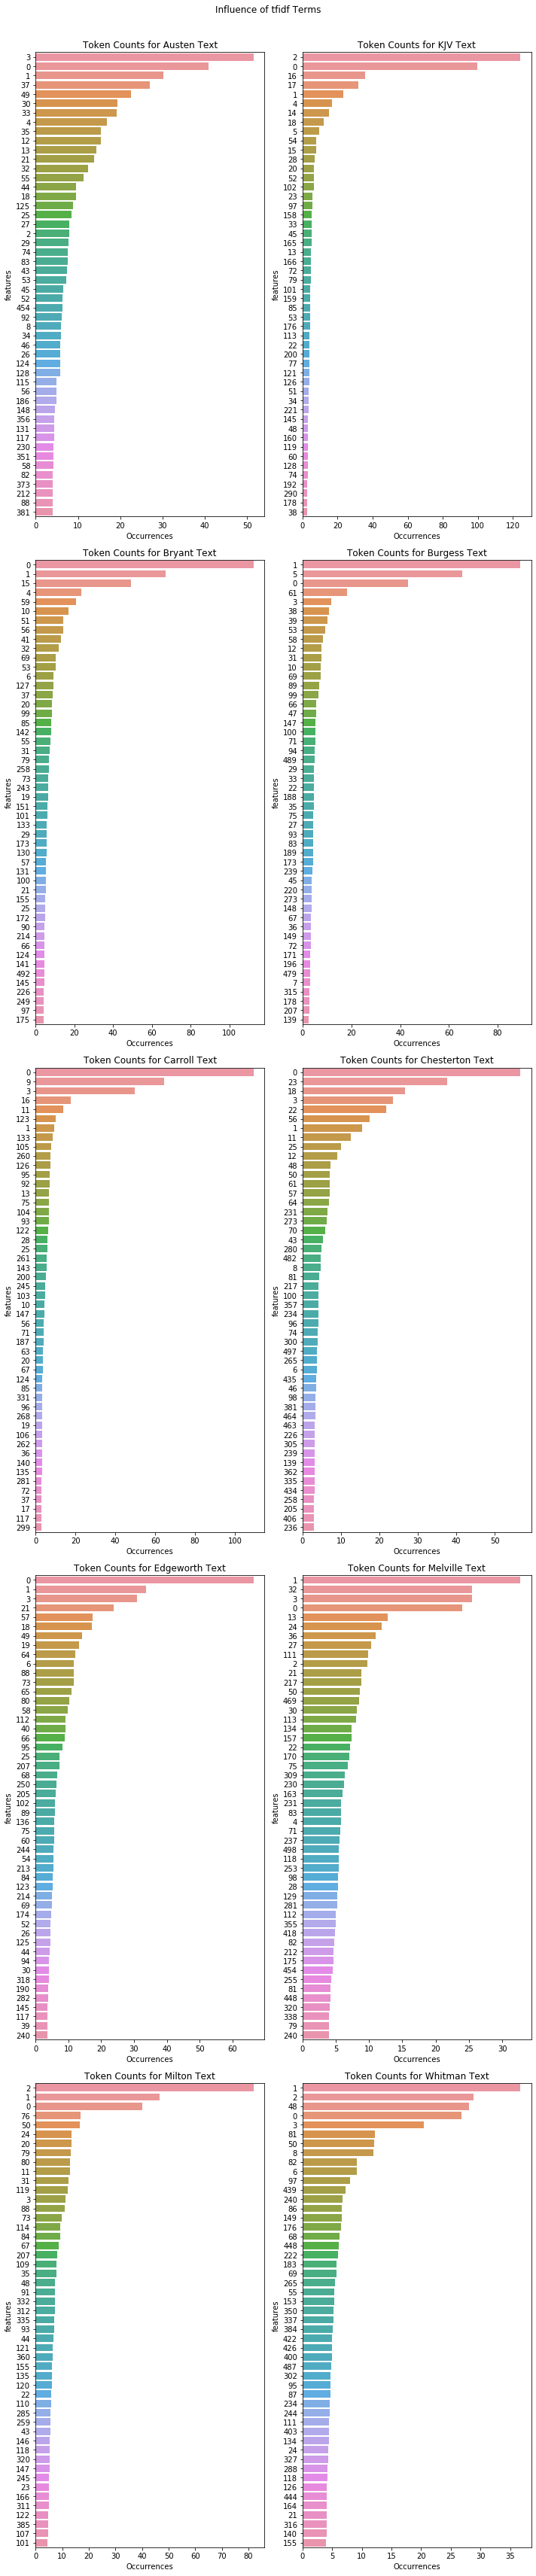

In [71]:
plt.figure(figsize=(10, 50))

for plot, author in enumerate(authors):
    data = component_cts.T[author].sort_values(ascending=False)[:50]
    plt.subplot(5, 2, plot+1)
    sns.barplot(y=data.index, x=data.values, orient='h', order=data.index)
    plt.title('Token Counts for {} Text'.format(author))
    plt.ylabel('features')
    plt.xlabel('Occurrences')
plt.suptitle('Influence of tfidf Terms')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])   
plt.show()

Between tfidf and SVD, interpreting our features is next to impossible without looking at some text. Features 0, 1, 2, 3, and 5 all score high on the above plots more than once. Let's take a look at the first few sentences that score highest for these features.

### Exploring tfidf features through textual analysis

#### Feature '0'

In [72]:
for sentence in sents_by_component.sort_values(by='0', axis=0, 
                                               ascending=False)['text_sent'][:10]:
    print (sentence)
    print()

she said .

she said .

she said .

she said .

she said .

she said .

she said .

she said .

she said .

she said .



Looks like feature 0 is the bigram "she said." Not very helpful except in distinguishing books that may have no female characters who speak.

#### Feature '1'

In [73]:
for sentence in sents_by_component.sort_values(by='1', axis=0, 
                                               ascending=False)['text_sent'][:10]:
    print (sentence)
    print()

" One had rather , on such occasions , do too much than too little .

Little was to be hoped from them .

he could spare so considerable a sum with little inconvenience ."

Then Little Joe gave a funny little gasp .

Once upon a time there was a little old woman and a little old man , and they lived all alone in a little old house .

The frightened fish Little Joe chased out of the little pools up above swam down the Laughing Brook , because , you know , Little Joe was behind them , and there was nowhere else for them to go .

It seemed to Little Joe that he never would come .

They were Little Joe Otter and Buster Bear .

Now Little Joe is good - natured and full of fun as a rule , and after he had reached home and his temper had cooled off a little , he began to see the joke on himself , how when he had worked so hard to frighten the fish in the little pools of the Laughing Brook so that Buster Bear should not catch any , he had all the time been driving them right into Buster ' s pa

It could be that feature 1 more or less coincides with 'little.'

#### Feature '2'

In [74]:
for sentence in sents_by_component.sort_values(by='2', axis=0, 
                                               ascending=False)['text_sent'][:10]:
    print (sentence)
    print()

Because thou hast , though throned in highest bliss Equal to God , and equally enjoying God - like fruition , quitted all , to save A world from utter loss , and hast been found By merit more than birthright Son of God , Found worthiest to be so by being good , Far more than great or high ; because in thee Love hath abounded more than glory abounds ; Therefore thy humiliation shall exalt With thee thy manhood also to this throne : Here shalt thou sit incarnate , here shalt reign Both God and Man , Son both of God and Man , Anointed universal King ; all power I give thee ; reign for ever , and assume Thy merits ; under thee , as head supreme , Thrones , Princedoms , Powers , Dominions , I reduce : All knees to thee shall bow , of them that bide In Heaven , or Earth , or under Earth in Hell .

28 : 13 And , behold , the LORD stood above it , and said , I am the LORD God of Abraham thy father , and the God of Isaac : the land whereon thou liest , to thee will I give it , and to thy seed ;

Feature 2 is bringing up sentences that appear to be from the bible. The numbers marking the passages may play a role. The use of archaic pronouns like "thee," "thy," and "thou" may also be incorporated. Perhaps there is also the use of "lord" and/or "god."

#### Feature '3'

In [75]:
for sentence in sents_by_component.sort_values(by='3', axis=0, 
                                               ascending=False)['text_sent'][:10]:
    print (sentence)
    print()

Oh !

Oh !

" Oh , pugh !

Oh !

" Oh !

" Oh !

" Oh !

Oh !

Oh !

Oh !



Feature 3 sentences appear to all contain "oh" and "!" with and without other words.

#### Feature '5'

In [76]:
for sentence in sents_by_component.sort_values(by='5', axis=0, 
                                               ascending=False)['text_sent'][:10]:
    print (sentence)
    print()

Then we will lead him to where Buster Bear is .

It was the footprint of Buster Bear .

It must be that for once he has been smarter than Buster Bear ."

said Buster Bear .

Now Buster Bear is very smart .

You see Farmer Brown ' s boy had just discovered Buster Bear .

FARMER BROWN ' S BOY AND BUSTER BEAR MEET

BUSTER BEAR IS GREATLY PUZZLED

BUSTER BEAR CARRIES OFF THE PAIL OF FARMER BROWN ' S BOY

FARMER BROWN ' S BOY AND BUSTER BEAR GROW CURIOUS



And finally feature 5 appears to be the bigram "buster bear."

Starting here, we can go ahead and run a train_test_split and evaluate our feature set created by tfidf and SVD.

## Clustering

### Determing cluster size using Elbow Method

In [77]:
# Create X and y variables
Xs = sents_by_component.drop(['text_sent', 'author', 'author_code'], axis=1)
Xs_norm = MinMaxScaler().fit_transform(Xs)
ys = sents_by_component['author_code']

# Create train test split
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs_norm, ys, test_size=0.25, random_state=5588)

# Create 4 equal subsections of the training set to verify model consistency
pca = PCA(n_components=2)
Xs_pca = pca.fit_transform(Xs_train)

# First split in half, then halve each half
x1, x2, xpca1, xpca2 = train_test_split(Xs_train, Xs_pca, test_size=0.5, random_state=5588)
X1, X2, XPCA1, XPCA2 = train_test_split(x1, xpca1, test_size=0.5, random_state=5588)
X3, X4, XPCA3, XPCA4 = train_test_split(x2, xpca2, test_size=0.5, random_state=5588)

subsets = [X1, X2, X3, X4]

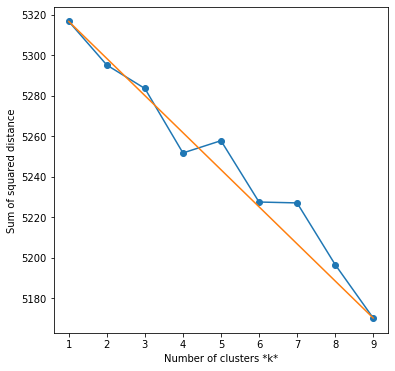

Optimal number of clusters: 7


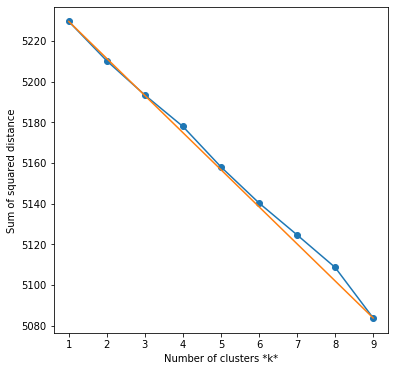

Optimal number of clusters: 8


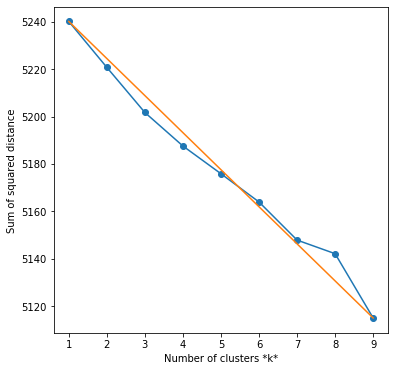

Optimal number of clusters: 8


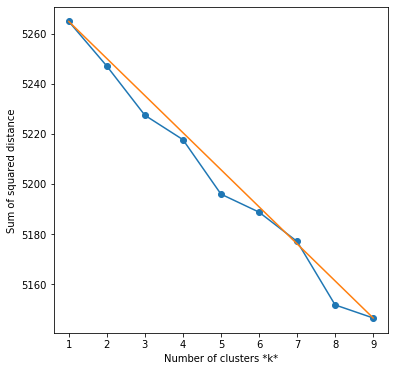

Optimal number of clusters: 5


In [78]:
it = 1
K = range(1, 10)
for X in subsets:
    sse = []
    list_k = list(range(1, 10))

    for k in list_k:
        km = KMeans(n_clusters=k, random_state=5588)
        km.fit(X)
        sse.append(km.inertia_)

    # Create coordinates for line segment to plot start point to end point
    x1, y1 = 1, sse[0]
    x2, y2 = 9, sse[-1]
    
    # Plot sse against k
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse, '-o')
    plt.plot((x1, x2), (y1, y2))
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance');# Determine distortion for each value of k clusters
    plt.show()
    
    # Determing optimal cluster size, best balance between within-cluster homogeneity and 
    # cluster diversity by finding point furthest from straight line (x1, y1), (x2, y2)
    distances = []
    for i in range(len(sse)):
        x0 = i + 1
        y0 = sse[i]
        numerator = abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2* x1)
        denominator = ((y2 - y1)**2 + (x2 - x1)**2)**0.5
        distances.append(numerator/denominator)
    # Return best n_clusters value
    print('Optimal number of clusters:', distances.index(max(distances)) + 1)
    it += 1

Well, we're not seeing a conclusive elbow here. But it looks like 8 would be a good place to start.

### K-Means with K = 8 clusters

In [79]:
kmean = KMeans(n_clusters=8, random_state=5588)
kmean.fit(Xs_train, ys_train)
y_preds = kmean.predict(Xs_test)
print(pd.crosstab(ys_test, y_preds))

col_0         0  1  2  3  4   5  6    7
author_code                            
0             0  0  0  2  1   9  0  191
1             0  0  0  2  0  30  2  154
2             0  9  7  3  0  39  0  188
3             0  0  0  3  0   5  4  164
4             0  0  0  7  1  48  2  159
5            17  0  0  4  2  17  6  158
6             0  1  0  1  0  27  1  173
7             0  0  0  4  0   4  0  203
8             0  0  0  3  0   1  1  170
9             0  0  1  2  0   2  0  196


Already it isn't looking very hopeful with the  cluster model - we see cluster 7 holds the majority of the sentences. The other clusters hold anywhere from 4 to 182 sentences. Let's see what's in these clusters.

#### Cluster 0 analysis

In [80]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 0
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==0) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Chesterton
Gregory gave through the trap the address of an obscure public - house on the Chiswick bank of the river .

Chesterton
" Comrade Gregory ," he said , " I suppose this man is a delegate ?"

Chesterton
" It was you that entrapped me ," began Gregory , shaking from head to foot , " entrapped me into "

Chesterton
" And now , my dear Mr . Syme ," said Gregory , throwing himself in an expansive manner on the bench under the largest bomb , " now we are quite cosy , so let us talk properly .

Chesterton
With a gesture that revealed the shop - walker , he led Syme down a short , iron - bound passage , the still agonised Gregory following feverishly at their heels .

Chesterton
" Does anyone oppose the election of Comrade Gregory ?"

Chesterton
Gregory resumed his seat and passed his hand across his forehead .

Chesterton
cried the chaotic Gregory .

Chesterton
Gregory , taken by surprise , looked down and muttered the name of Syme ; but Syme replied almost pertly 

Chesterton
Do we 

It looks like cluster 0 features "Gregory."

#### Cluster 1 analysis

In [81]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 1
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==1) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
" You can ' t catch me , I ' m the Gingerbread Man !"

Bryant
said the little Gingerbread Boy , " I am a quarter gone !"

Edgeworth
First , I ' d buy pocketfuls of gingerbread ; then I ' d buy ever so many apples and nuts .



Cluster 1 looks like "gingerbread" is the key term.

#### Cluster 2 analysis

In [82]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 2
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==2) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Bryant
as fast as you can !

Bryant
as fast as you can !

Bryant
as fast as you can !

Bryant
And the Wind blew him straight up to the top of the church steeple , and stuck him there , fast !

Bryant
as fast as you can !

Bryant
as fast as you can !

Bryant
as fast as you can !

Whitman
We closed with him , the yards entangled , the cannon touch ' d , My captain lash ' d fast with his own hands .



All sentences of cluster 2 have the term "fast."

#### Cluster 3 analysis

In [83]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 3
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==3) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Austen
Margaret ' s sagacity was not always displayed in a way so satisfactory to her sister .

Austen
The ladies had passed near it in their way along the valley , but it was screened from their view at home by the projection of a hill .

KJV
32 : 1 And Jacob went on his way , and the angels of God met him .

KJV
24 : 62 And Isaac came from the way of the well Lahairoi ; for he dwelt in the south country .

Bryant
They had a ladder from the floor to the loft , and on the ladder they tied a vine all the way up to the loft , to look like the wonderful beanstalk .

Bryant
At last the old Fox thought out a way to catch the little Red Hen .

Bryant
When he had hoppity - kicked a good way , and was near Madrid , he came to a clump of bushes , where the Wind was caught fast .

Burgess
When Blacky and Sammy saw him coming , they moved a little farther in to the Green Forest , still screaming in the most excited way .

Burgess
He heard Sammy Jay way off in the distance screaming , " Thief !

B

The word "way" appears to be the common denominator here.

#### Cluster 4 analysis

In [84]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 4
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==4) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Austen
A present of fifty pounds , now and then , will prevent their ever being distressed for money , and will , I think , be amply discharging my promise to my father ."

Carroll
said Alice , quite forgetting her promise .

Chesterton
Would you give me , for my own safety , a little promise of the same kind ? "

Chesterton
" What did I promise you ?"



In cluster 4 almost all sentences contain the word "promise."

#### Cluster 5 analysis

In [85]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 5
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==5) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Austen
said almost every body .

Austen
" Upon my soul ," said he , " I do not know much about him as to all THAT .

Austen
" Do not be alarmed ," said Miss Dashwood , " nothing of the kind will be done ; for my mother will never have money enough to attempt it ."

Austen
" I am ," said he .

Austen
She had nothing to say one day that she had not said the day before .

Austen
" It is enough ," said she ; " to say that he is unlike Fanny is enough .

Austen
pray , Miss Margaret , let us know all about it ," said Mrs . Jennings .

Austen
" You know him then ," said Mrs . Dashwood .

Austen
said Sir John .

KJV
15 : 5 And he brought him forth abroad , and said , Look now toward heaven , and tell the stars , if thou be able to number them : and he said unto him , So shall thy seed be .

KJV
And he said , I know not : Am I my brother ' s keeper ?

KJV
30 : 13 And Leah said , Happy am I , for the daughters will call me blessed : and she called his name Asher .

KJV
31 : 48 And Laban said , T

Looks like the only commonality is the word "said."

#### Cluster 6 analysis

In [86]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 6
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==6) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

KJV
24 : 47 And I asked her , and said , Whose daughter art thou ?

KJV
32 : 29 And Jacob asked him , and said , Tell me , I pray thee , thy name .

Burgess
asked Sammy Jay eagerly .

Burgess
asked Little Joe Otter , as Buster Bear sat for the longest time without moving .

Burgess
asked Grandfather Frog .

Burgess
asked Farmer Brown ' s boy of his mother .

Carroll
Alice asked .

Carroll
she asked .

Chesterton
asked Syme .

Chesterton
asked Syme .

Chesterton
asked Syme .

Chesterton
he asked .

Chesterton
she asked .

Chesterton
" Do you mean ," asked Syme , " that there is really as much connection between crime and the modern intellect as all that ?"

Edgeworth
" And when she asked you where I was gone , how came you to say that you did not know ?"

Milton
This also thy request , with caution asked , Obtain ; though to recount almighty works What words or tongue of Seraph can suffice , Or heart of man suffice to comprehend ?



Our commonality here is "asked."

#### Cluster 7 analysis

In [87]:
test_df = sents_by_component.iloc[ys_test.index, :].copy()
test_df['cluster'] = y_preds

# Print sentences in cluster 7
for auth_idx, author in enumerate(authors): 
    for sent_idx, sentence in enumerate(test_df[(test_df['cluster']==7) & 
                                        (test_df['author_code']==auth_idx)]['text_sent']):
        if sent_idx < 10:
            print(author)
            print(sentence)
            print()

Austen
But two advantages will proceed from this delay .

Austen
I only know that I never yet heard her admit any instance of a second attachment ' s being pardonable ."

Austen
I require so much !

Austen


Austen
But she had seen enough of him to join in all the admiration of the others , and with an energy which always adorned her praise .

Austen
A continuance in a place where everything reminded her of former delight , was exactly what suited her mind .

Austen
A very decent shot , and there is not a bolder rider in England ."

Austen
Mr . John Dashwood told his mother again and again how exceedingly sorry he was that she had taken a house at such a distance from Norland as to prevent his being of any service to her in removing her furniture .

Austen
Of John I know very little , though we have lived together for years ; but of Willoughby my judgment has long been formed ."

Austen
Their tendency is gross and illiberal ; and if their construction could ever be deemed clever , time

We don't see much in the way of valuable insights with an 8 cluster model using the tfidf features. The only positive from this point in the analysis is: it seems that it may perform a bit better segmentation than the BOW clustering models. 

Let's keep moving and explore the supervised methods on these features to see what we can come up with.

## Supervised modeling of tfidf features

### Logistic Regression

In [88]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000, multi_class='auto', random_state=5588)
accuracy = cross_val_score(logreg, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.67104184 0.66776316 0.68039539 0.66171617 0.68373245]
Avg accuracy score: 0.6729298013504351


Logistic Regression accuracy on tfidf test set: 0.666501976284585



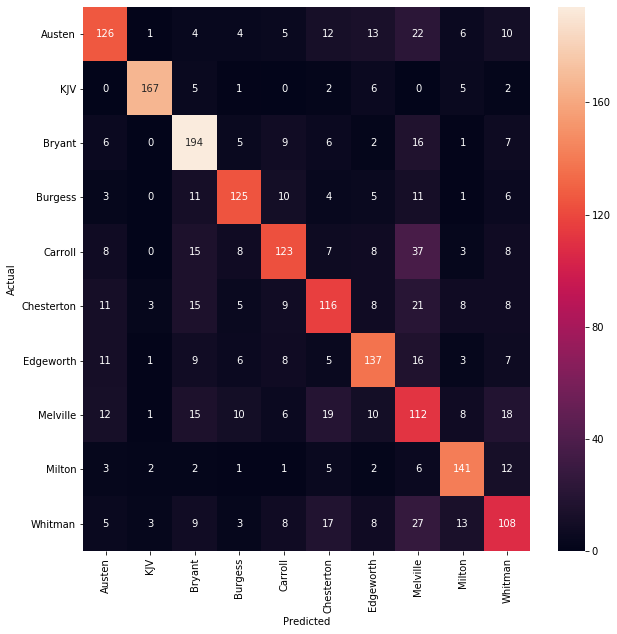

In [90]:
logreg.fit(Xs_train, ys_train)
logreg_pred = logreg.predict(Xs_test)

print("Logistic Regression accuracy on tfidf test set:", metrics.accuracy_score(ys_test, logreg_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, logreg_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### LinearSVC

In [91]:
LSVC = LinearSVC(dual=False, max_iter=1000, random_state=5588)
accuracy = cross_val_score(LSVC, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.67924528 0.67680921 0.6878089  0.67079208 0.68620974]
Avg accuracy score: 0.680173042595438


LSVC accuracy on tfidf test set: 0.6734189723320159



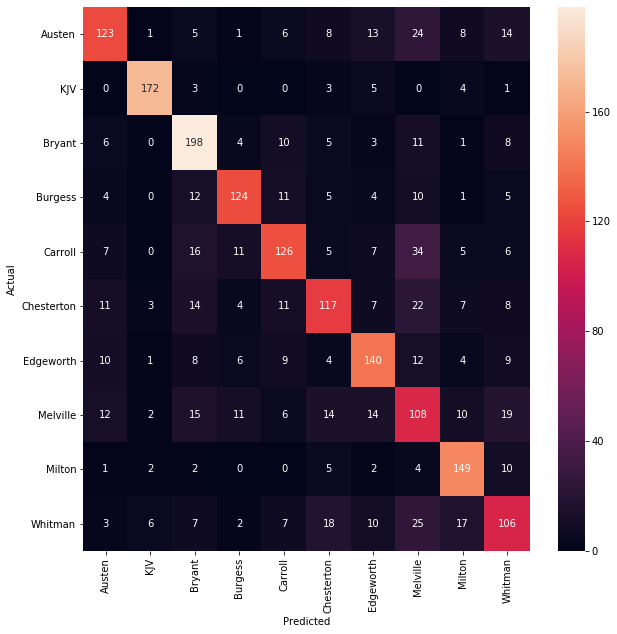

In [92]:
LSVC.fit(Xs_train, ys_train)
LSVC_pred = LSVC.predict(Xs_test)

print("LSVC accuracy on tfidf test set:", metrics.accuracy_score(ys_test, LSVC_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, LSVC_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Random Forest Classifier

In [93]:
forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=5588)
accuracy = cross_val_score(forest, Xs_train, ys_train, scoring='accuracy', cv=5)
print("CV accuracy scores:", accuracy)
print('Avg accuracy score:', np.mean(accuracy))

CV accuracy scores: [0.47826087 0.49342105 0.49505766 0.50247525 0.47563997]
Avg accuracy score: 0.488970959463405


Random Forest accuracy on test set: 0.4743083003952569



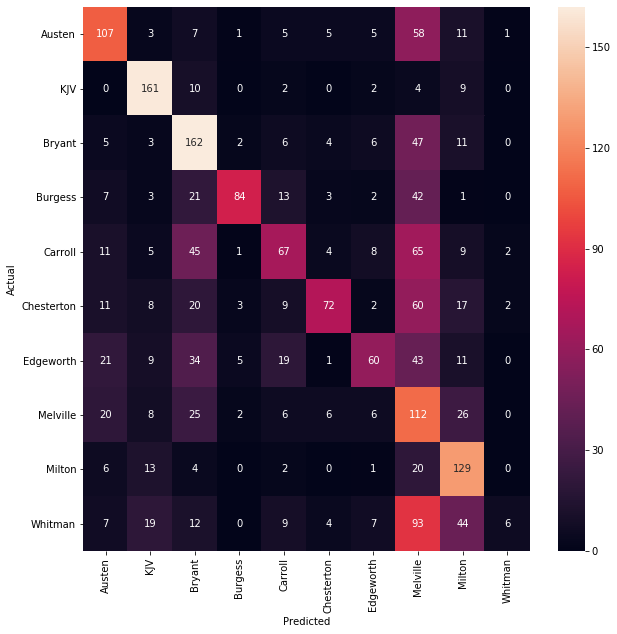

In [94]:
forest.fit(Xs_train, ys_train)
forest_pred = forest.predict(Xs_test)

print("Random Forest accuracy on test set:", metrics.accuracy_score(ys_test, forest_pred))
print()

conf_mat = metrics.confusion_matrix(ys_test, forest_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=authors, yticklabels=authors)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Final analysis

## Summary of findings

We found that clustering was, for the most part, very unsuccessful with this data set. It seemed that aside from a few cases, rather than building clusters from multiple lemmas, our K-Means models would only use one lemma per cluster. This resulted in very small clusters, unable to capture the entirety of an author's sentences.

That said, the silver lining is that we achieved an accuracy of 0.67 using our tfidf feature set and a LinearSVC model. This is very good performance lift on a set with a space of 10 possible authors to classify, and a base accuracy of random guessing being 0.10. 


## Issues and areas of future exploration

First off, this data set and project has problems that I believe this analysis wouldn't be able to address. Is text author classification a useful tool? Perhaps for applications like plagiarism detection or authenticating newly discovered texts and art. I'm of the opinion that using basic NLP tools such as these, the work required to create high performing unsupervised models would not be worthwhile given the small use cases.

Certainly one could go on to spend hours tweaking their text cleaning process, tuning BOW and tfidf feature selection, and tuning and comparing different clustering models. I would also import additional texts and try different authors from different periods and select sentences randomly from each text (rather than selecting the first 1000). 

But at the end of the day, I'd start from scratch on a much more realistic challenge with much broader applications:  sentiment analysis from product/business reviews.